In [176]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils
from square_sequences import generate_sequences
from StepV4 import StepByStep
from plots import *
import seaborn as sns

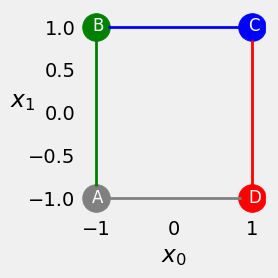

In [177]:
fig = counter_vs_clock(draw_arrows=False)

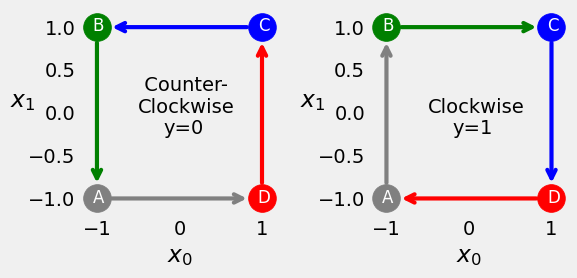

In [178]:
fig = counter_vs_clock()

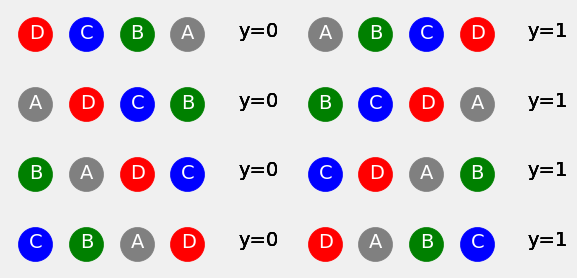

In [179]:
fig = plot_sequences()

In [180]:
points, directions = generate_sequences(n=128, seed=13)

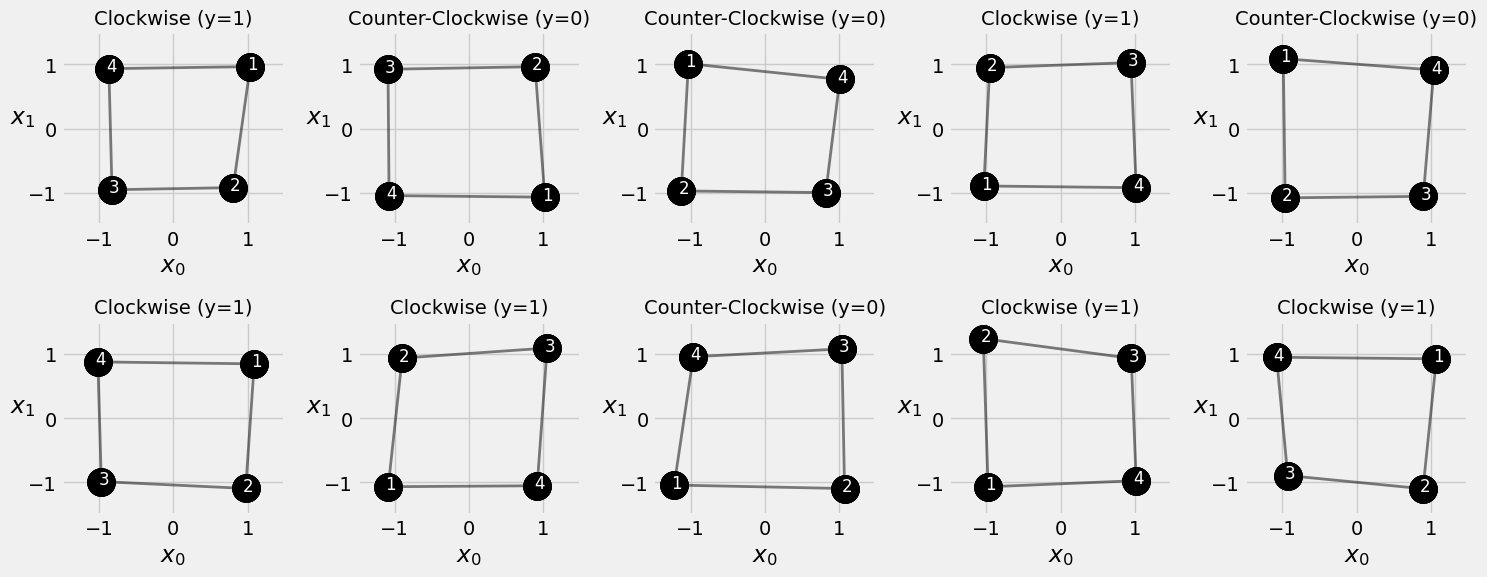

In [181]:
fig = plot_data(points, directions)

In [182]:
hidden_state = torch.zeros(2)
hidden_state

tensor([0., 0.])

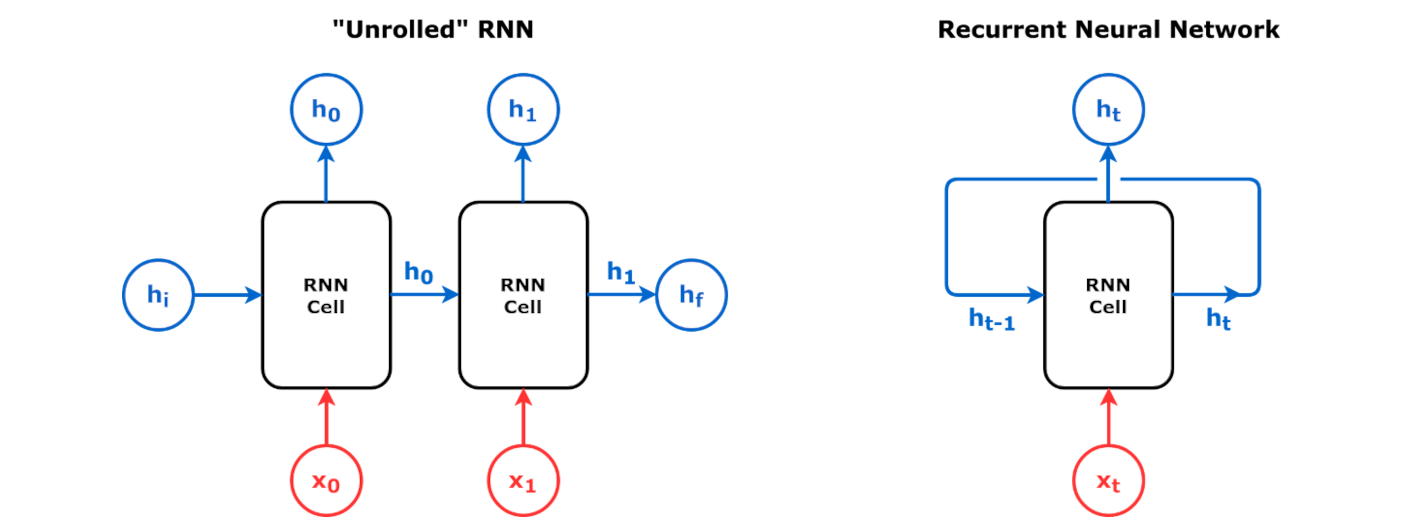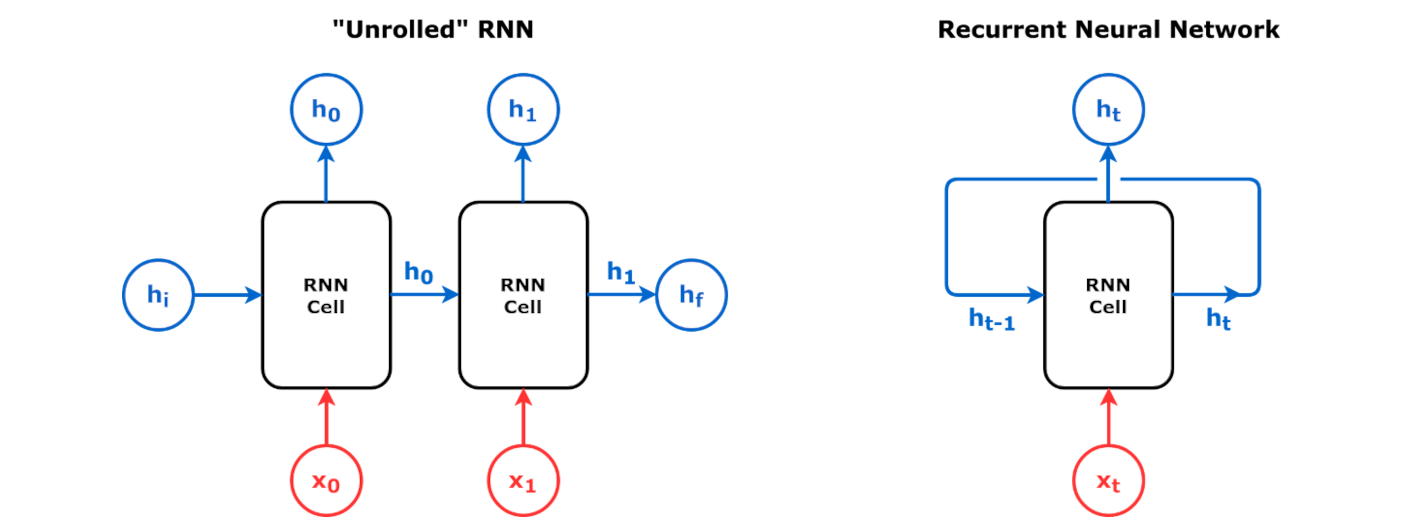

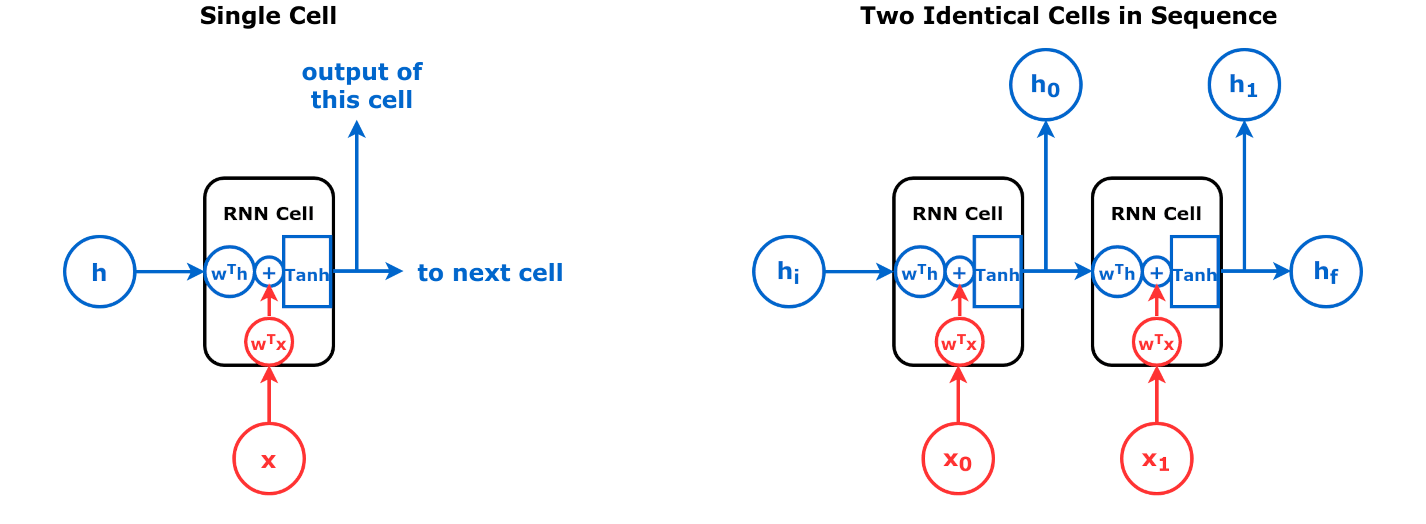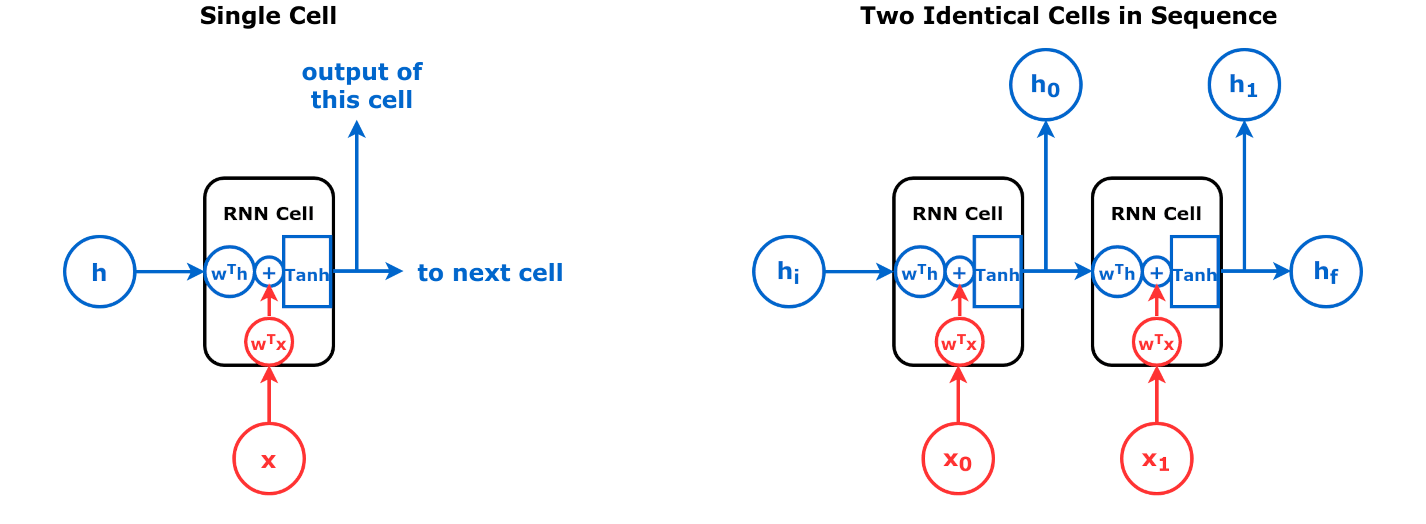


\begin{array}
&\text{RNN}: &\color{#0066CC}{t_h}&\color{#0066CC}{=}&\color{#0066CC}{W_{hh}}&\color{#0066CC}{h_{t-1}}&\color{#0066CC}{+}&\color{#0066CC}{b_{hh}}
\\
&\color{red}{t_x}& \color{red}{=} &\color{red}{W_{ih}}&\color{red}{x_{t}}&\color{red}{+}&\color{red}{b_{ih}}
\\
&\color{#0066CC}{h_t}&\color{#0066CC}{=}&\color{#0066CC}{\text{tanh}}&\color{#0066CC}{(t_h}&\color{#0066CC}{+}&\color{#0066CC}{t_x)}
\end{array}

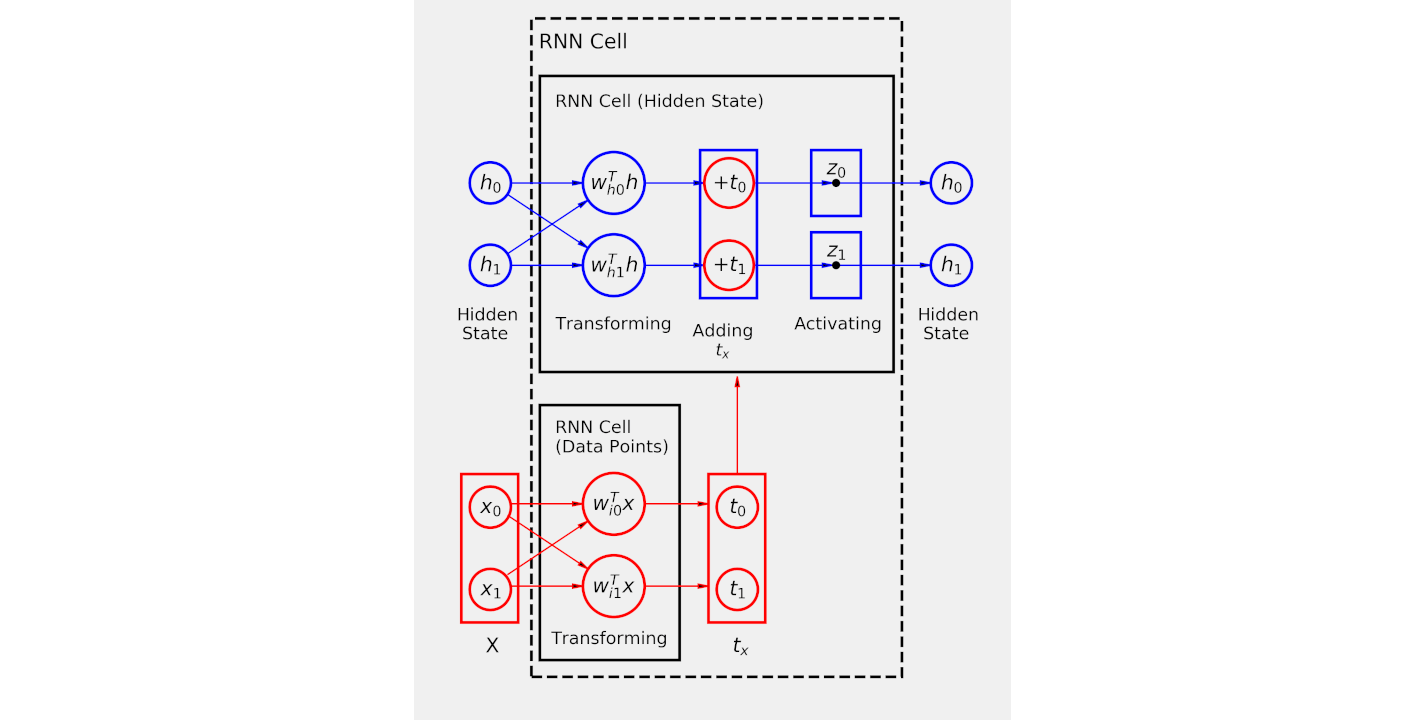

In [183]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn_cell = nn.RNNCell(n_features, hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])

In [184]:
linear_input = nn.Linear(n_features, hidden_dim)
linear_hidden = nn.Linear(hidden_dim, hidden_dim)

with torch.no_grad():
    linear_input.weight = nn.Parameter(rnn_state['weight_ih'])
    linear_input.bias = nn.Parameter(rnn_state['bias_ih'])
    
    linear_hidden.weight = nn.Parameter(rnn_state['weight_hh'])
    linear_hidden.bias = nn.Parameter(rnn_state['bias_hh'])

In [185]:
initial_hidden = torch.zeros(1, hidden_dim)
initial_hidden

tensor([[0., 0.]])

In [186]:
th = linear_hidden(initial_hidden)
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

In [187]:
X = torch.as_tensor(points[0]).float()
X

tensor([[ 1.0349,  0.9661],
        [ 0.8055, -0.9169],
        [-0.8251, -0.9499],
        [-0.8670,  0.9342]])

In [188]:
tx = linear_input(X[0:1])
tx

tensor([[0.7712, 1.4310]], grad_fn=<AddmmBackward0>)

In [189]:
adding = th + tx
adding

tensor([[0.4146, 1.1405]], grad_fn=<AddBackward0>)

In [190]:
torch.tanh(adding)

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

In [191]:
rnn_cell(X[0:1])

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

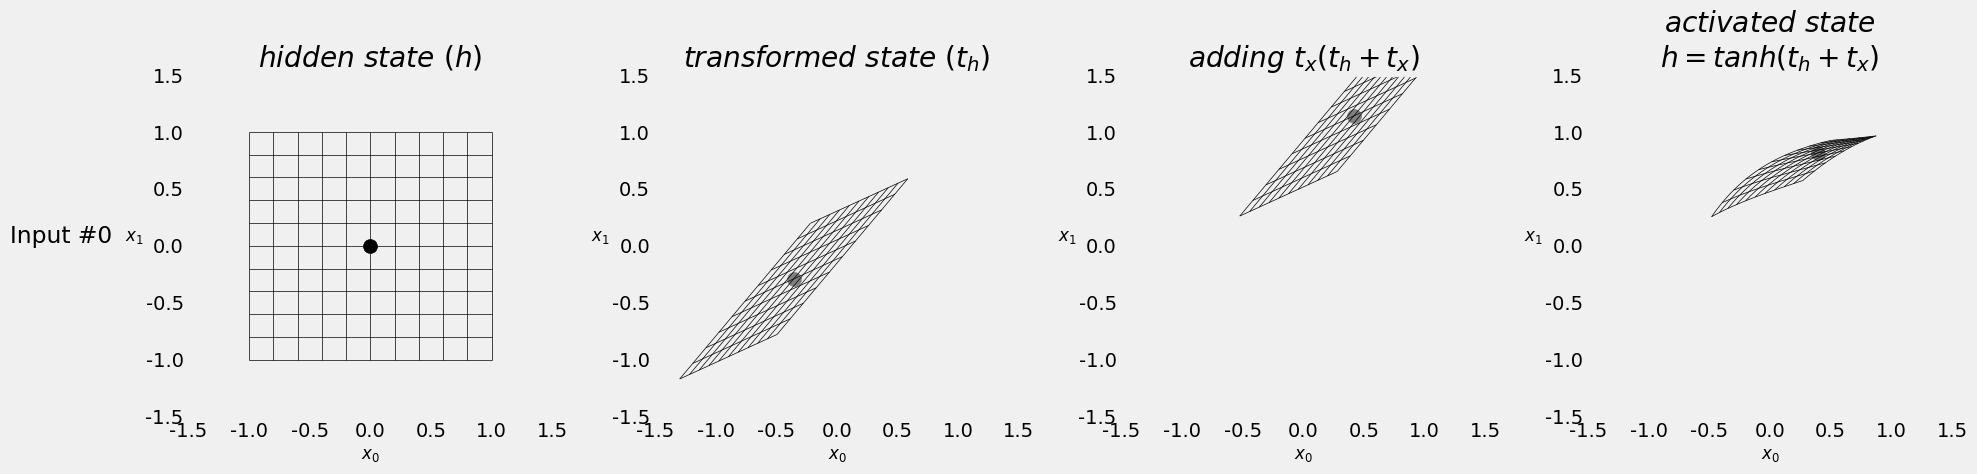

In [192]:
fig = figure8(linear_hidden, linear_input, X)

In [193]:
# WRONG!!!!
rnn_cell(X)

tensor([[ 0.3924,  0.8146],
        [ 0.7864,  0.5266],
        [-0.0047, -0.2897],
        [-0.6817,  0.1109]], grad_fn=<TanhBackward0>)

In [194]:
hidden = torch.zeros(1, hidden_dim)
for i in range(X.shape[0]):
    out = rnn_cell(X[i:i+1], hidden)
    print(out)
    hidden = out

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)
tensor([[ 0.4347, -0.0481]], grad_fn=<TanhBackward0>)
tensor([[-0.1521, -0.3367]], grad_fn=<TanhBackward0>)
tensor([[-0.5297,  0.3551]], grad_fn=<TanhBackward0>)


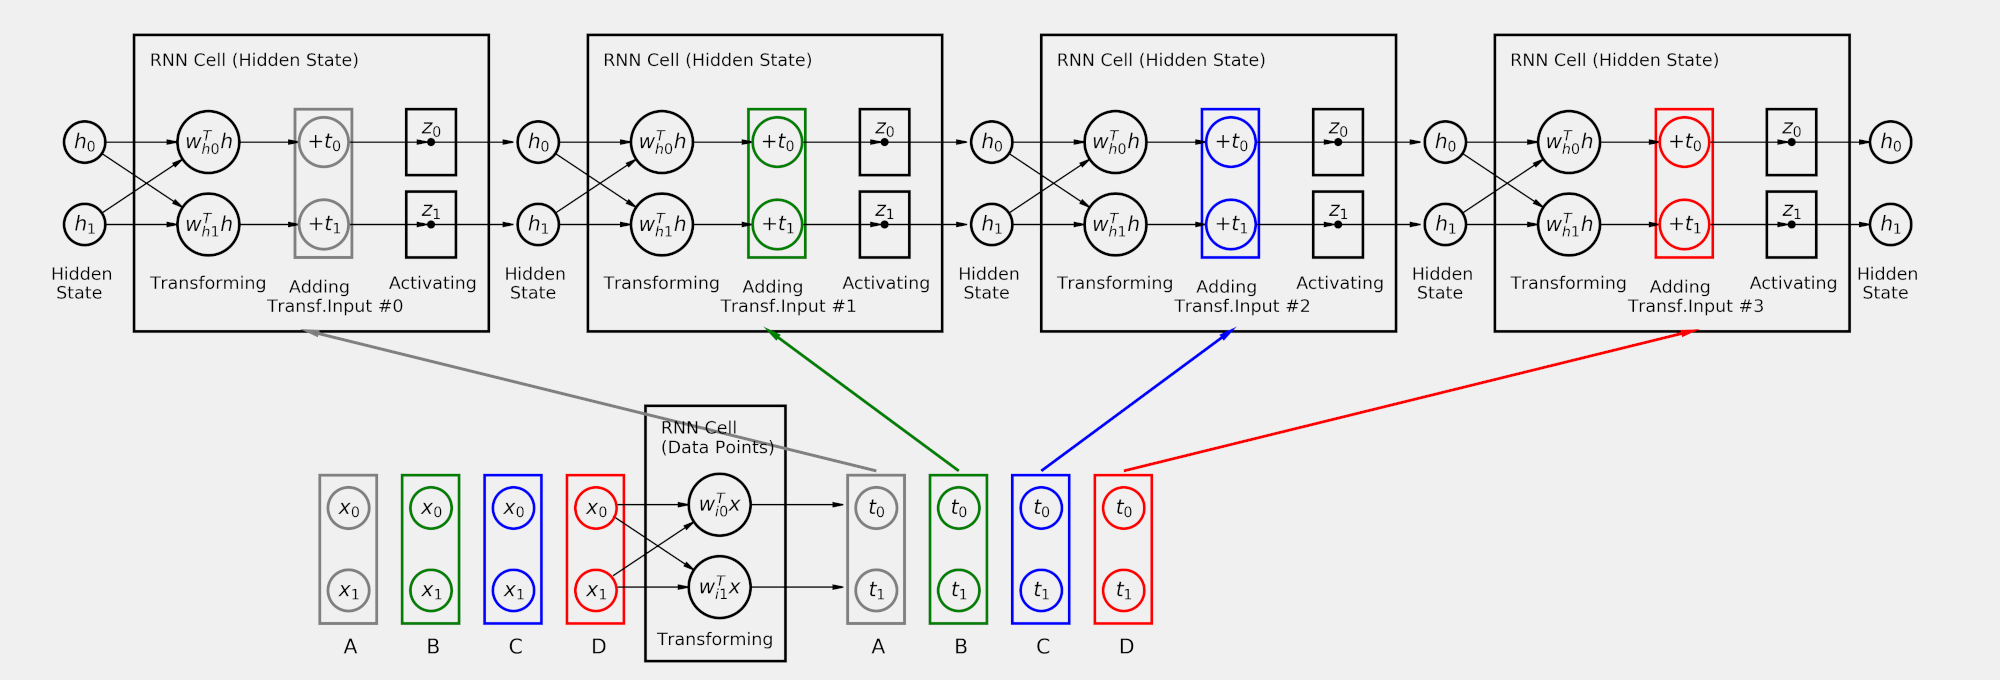

## ***RNN Layer***

In [195]:
n_features = 2
hidden_dim = 2

torch.manual_seed(19)
rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)

rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

## ***Shapes***

In [196]:
batch = torch.as_tensor(points[:3]).float()
batch.shape

torch.Size([3, 4, 2])

In [197]:
permuted_batch = batch.permute(1, 0, 2)
permuted_batch.shape

torch.Size([4, 3, 2])

In [198]:
torch.manual_seed(19)

rnn = nn.RNN(n_features, hidden_dim)
out, final_hidden = rnn(permuted_batch)
out.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

In [199]:
(out[-1] == final_hidden).all()

tensor(True)

In [200]:
batch_hidden = final_hidden.permute(1, 0, 2)
batch.shape

torch.Size([3, 4, 2])

In [201]:
torch.manual_seed(19)

rnn_batch_first = nn.RNN(n_features, hidden_dim, batch_first=True)
out, final_hidden = rnn_batch_first(batch)
out.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

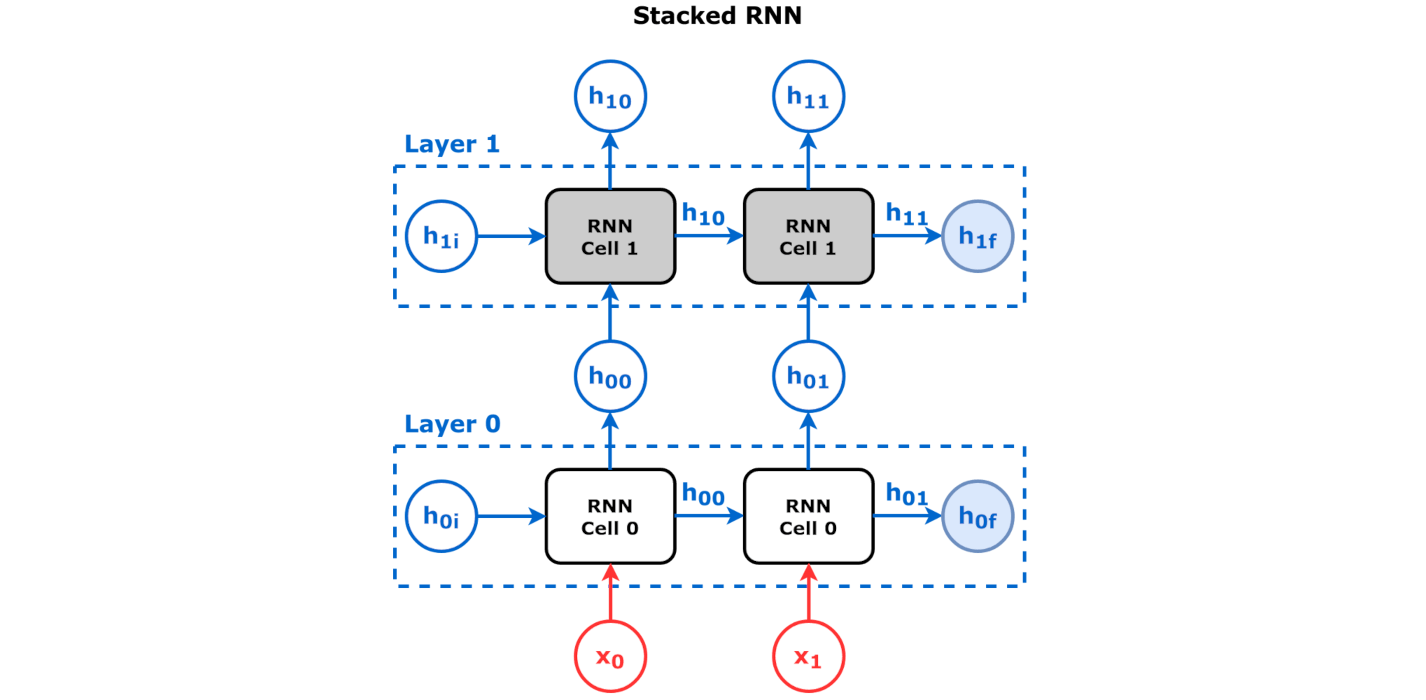

In [202]:
torch.manual_seed(19)
rnn_stacked = nn.RNN(input_size=2, hidden_size=2, num_layers=2, batch_first=True)
state = rnn_stacked.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l1',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l1',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l1', tensor([-0.3163, -0.2153])),
             ('bias_hh_l1', tensor([ 0.0722, -0.3242]))])

In [203]:
rnn_layer0 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_layer1 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_layer0.load_state_dict(dict(list(state.items())[:4]))
rnn_layer1.load_state_dict(dict([(k[:-1]+'0', v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

In [204]:
x = torch.as_tensor(points[0:1]).float()

In [205]:
out0, h0 = rnn_layer0(x)

In [206]:
out1, h1 = rnn_layer1(out0)

In [207]:
out1, torch.cat([h0, h1])

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<CatBackward0>))

In [208]:
out, hidden = rnn_stacked(x)
out, hidden

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<StackBackward0>))

In [209]:
(out[:, -1] == hidden.permute(1, 0, 2)[:, -1]).all()

tensor(True)

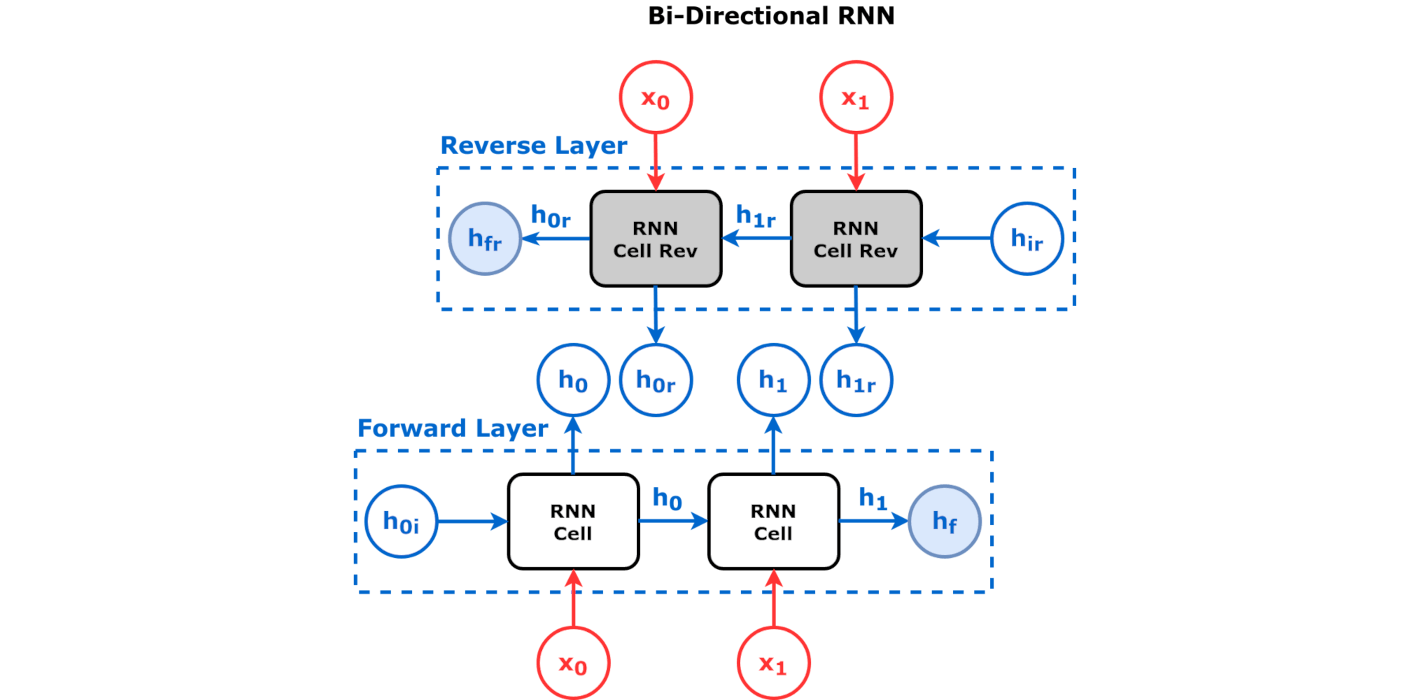

In [210]:
torch.manual_seed(19)
rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, bidirectional=True, batch_first=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l0_reverse',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l0_reverse', tensor([-0.3163, -0.2153])),
             ('bias_hh_l0_reverse', tensor([ 0.0722, -0.3242]))])

In [211]:
rnn_forward = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_reverse = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_forward.load_state_dict(dict(list(state.items())[:4]))
rnn_reverse.load_state_dict(dict([(k[:-8], v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

In [212]:
x_rev = torch.flip(x, dims=[1]) # N, L, F
x_rev

tensor([[[-0.8670,  0.9342],
         [-0.8251, -0.9499],
         [ 0.8055, -0.9169],
         [ 1.0349,  0.9661]]])

In [213]:
out, h = rnn_forward(x)
out_rev, h_rev = rnn_reverse(x_rev)
out_rev_back = torch.flip(out_rev, dims=[1])

In [214]:
torch.cat([out, out_rev_back], dim=2), torch.cat([h, h_rev])

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<CatBackward0>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<CatBackward0>))

In [215]:
out, hidden = rnn_bidirect(x)
out, hidden

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<StackBackward0>))

In [216]:
out[:, -1] == hidden.permute(1, 0, 2).view(1, -1)

tensor([[ True,  True, False, False]])

## ***Square Model***

### ***Data Preparation***

In [217]:
test_points, test_directions = generate_sequences(seed=19)

In [218]:
train_data = TensorDataset(torch.as_tensor(points).float(), 
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(),
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [219]:
class SquareModel(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super().__init__()
        self.n_outputs = n_outputs
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.hidden = None
        
        self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, x):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(x)

        # only last item in sequence (N, 1, H)
        last_out_put = batch_first_output[:, -1]

        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_out_put)

        #  output (N, 1, n_outputs) -----> (N, n_outputs)
        out = out.view(-1, self.n_outputs)
        return out

In [243]:
torch.manual_seed(21)
model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [244]:
sbs_rnn = StepByStep(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

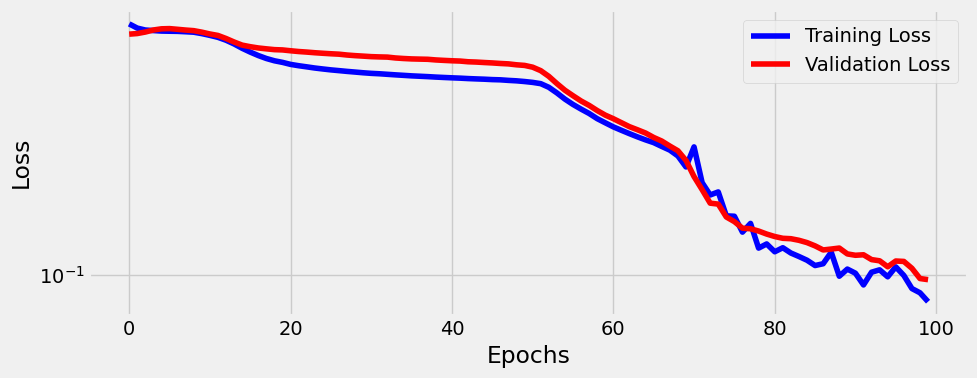

In [245]:
fig = sbs_rnn.plot_losses()

In [65]:
StepByStep.loader_apply(test_loader, sbs_rnn.correct)

tensor([[50, 53],
        [75, 75]])

## ***Visualizing the Model***

### ***Transformed Inputs***

In [66]:
state = model.basic_rnn.state_dict()
state['weight_ih_l0'], state['bias_ih_l0']

(tensor([[-0.5201, -2.6582],
         [-1.7018, -0.4989]], device='cuda:0'),
 tensor([0.8096, 0.8822], device='cuda:0'))

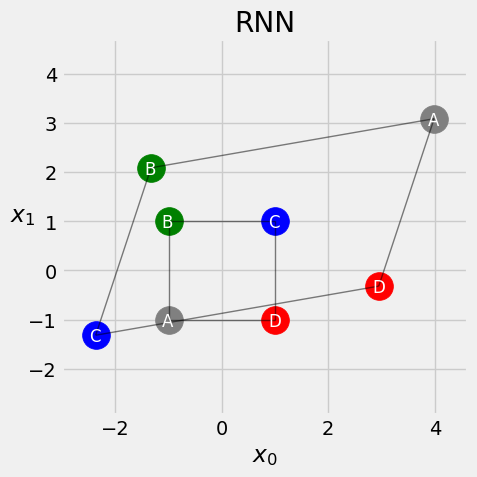

In [67]:
fig = figure13(model.basic_rnn)

### ***Hidden States***

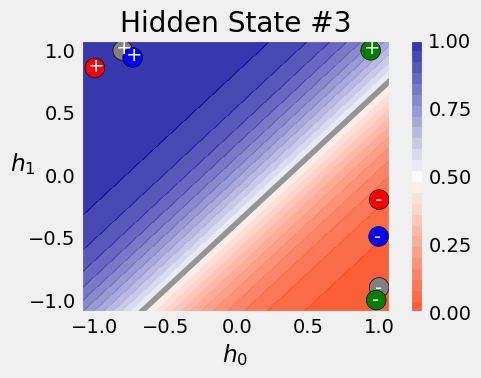

In [68]:
fig = canonical_contour(model)

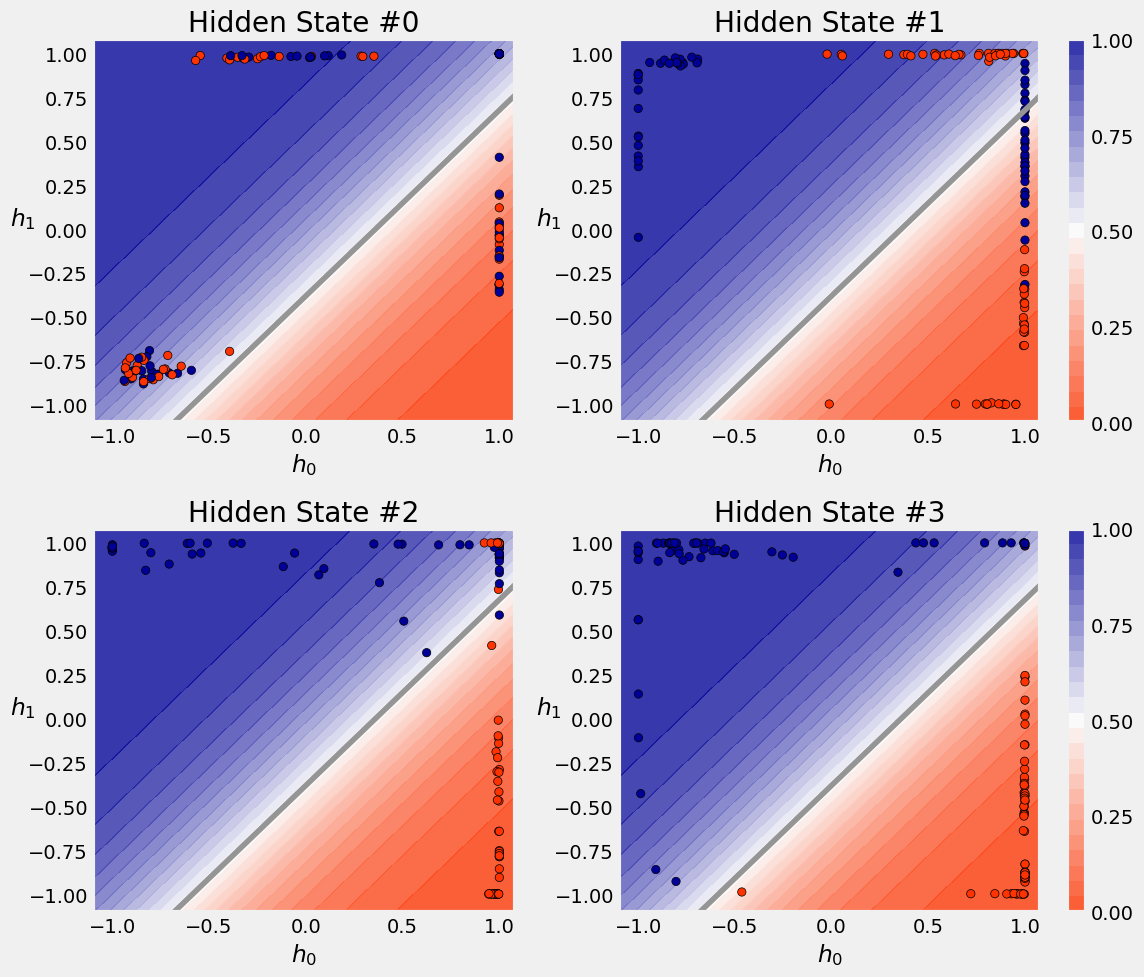

In [72]:
def hidden_states_contour(model, points, directions, cell=False, attr='hidden'):
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 12)
    
    hex_list = ['#FF3300', '#FFFFFF', '#000099']
    new_cmap = get_continuous_cmap(hex_list)
    
    device = list(model.parameters())[0].device.type

    for i in range(4):
        ci = i - (2 if i >= 2 else 0)
        ri = (i >= 2)
        ax = fig.add_subplot(gs[ri, ci*5+1:(ci+1)*5+1+(ci==1)])
        model(torch.as_tensor(points).float()[:, :i+1, :].to(device))
        probability_contour(ax, 
                            model.classifier, 
                            device, 
                            getattr(model, attr).detach().cpu().squeeze(), 
                            directions.astype(int), 
                            0.5, 
                            cm=new_cmap, 
                            cm_bright=ListedColormap(['#FF3300', '#000099']), cbar=ci==1)
        ax.set_title(f'Hidden State #{i}')
        ax.set_xlabel(r'$h_0$')
        ax.set_ylabel(r'$h_1$', rotation=0)
        
    fig.tight_layout()

    return fig

fig = hidden_states_contour(model, points, directions)

### ***The Journey of a Hidden State***

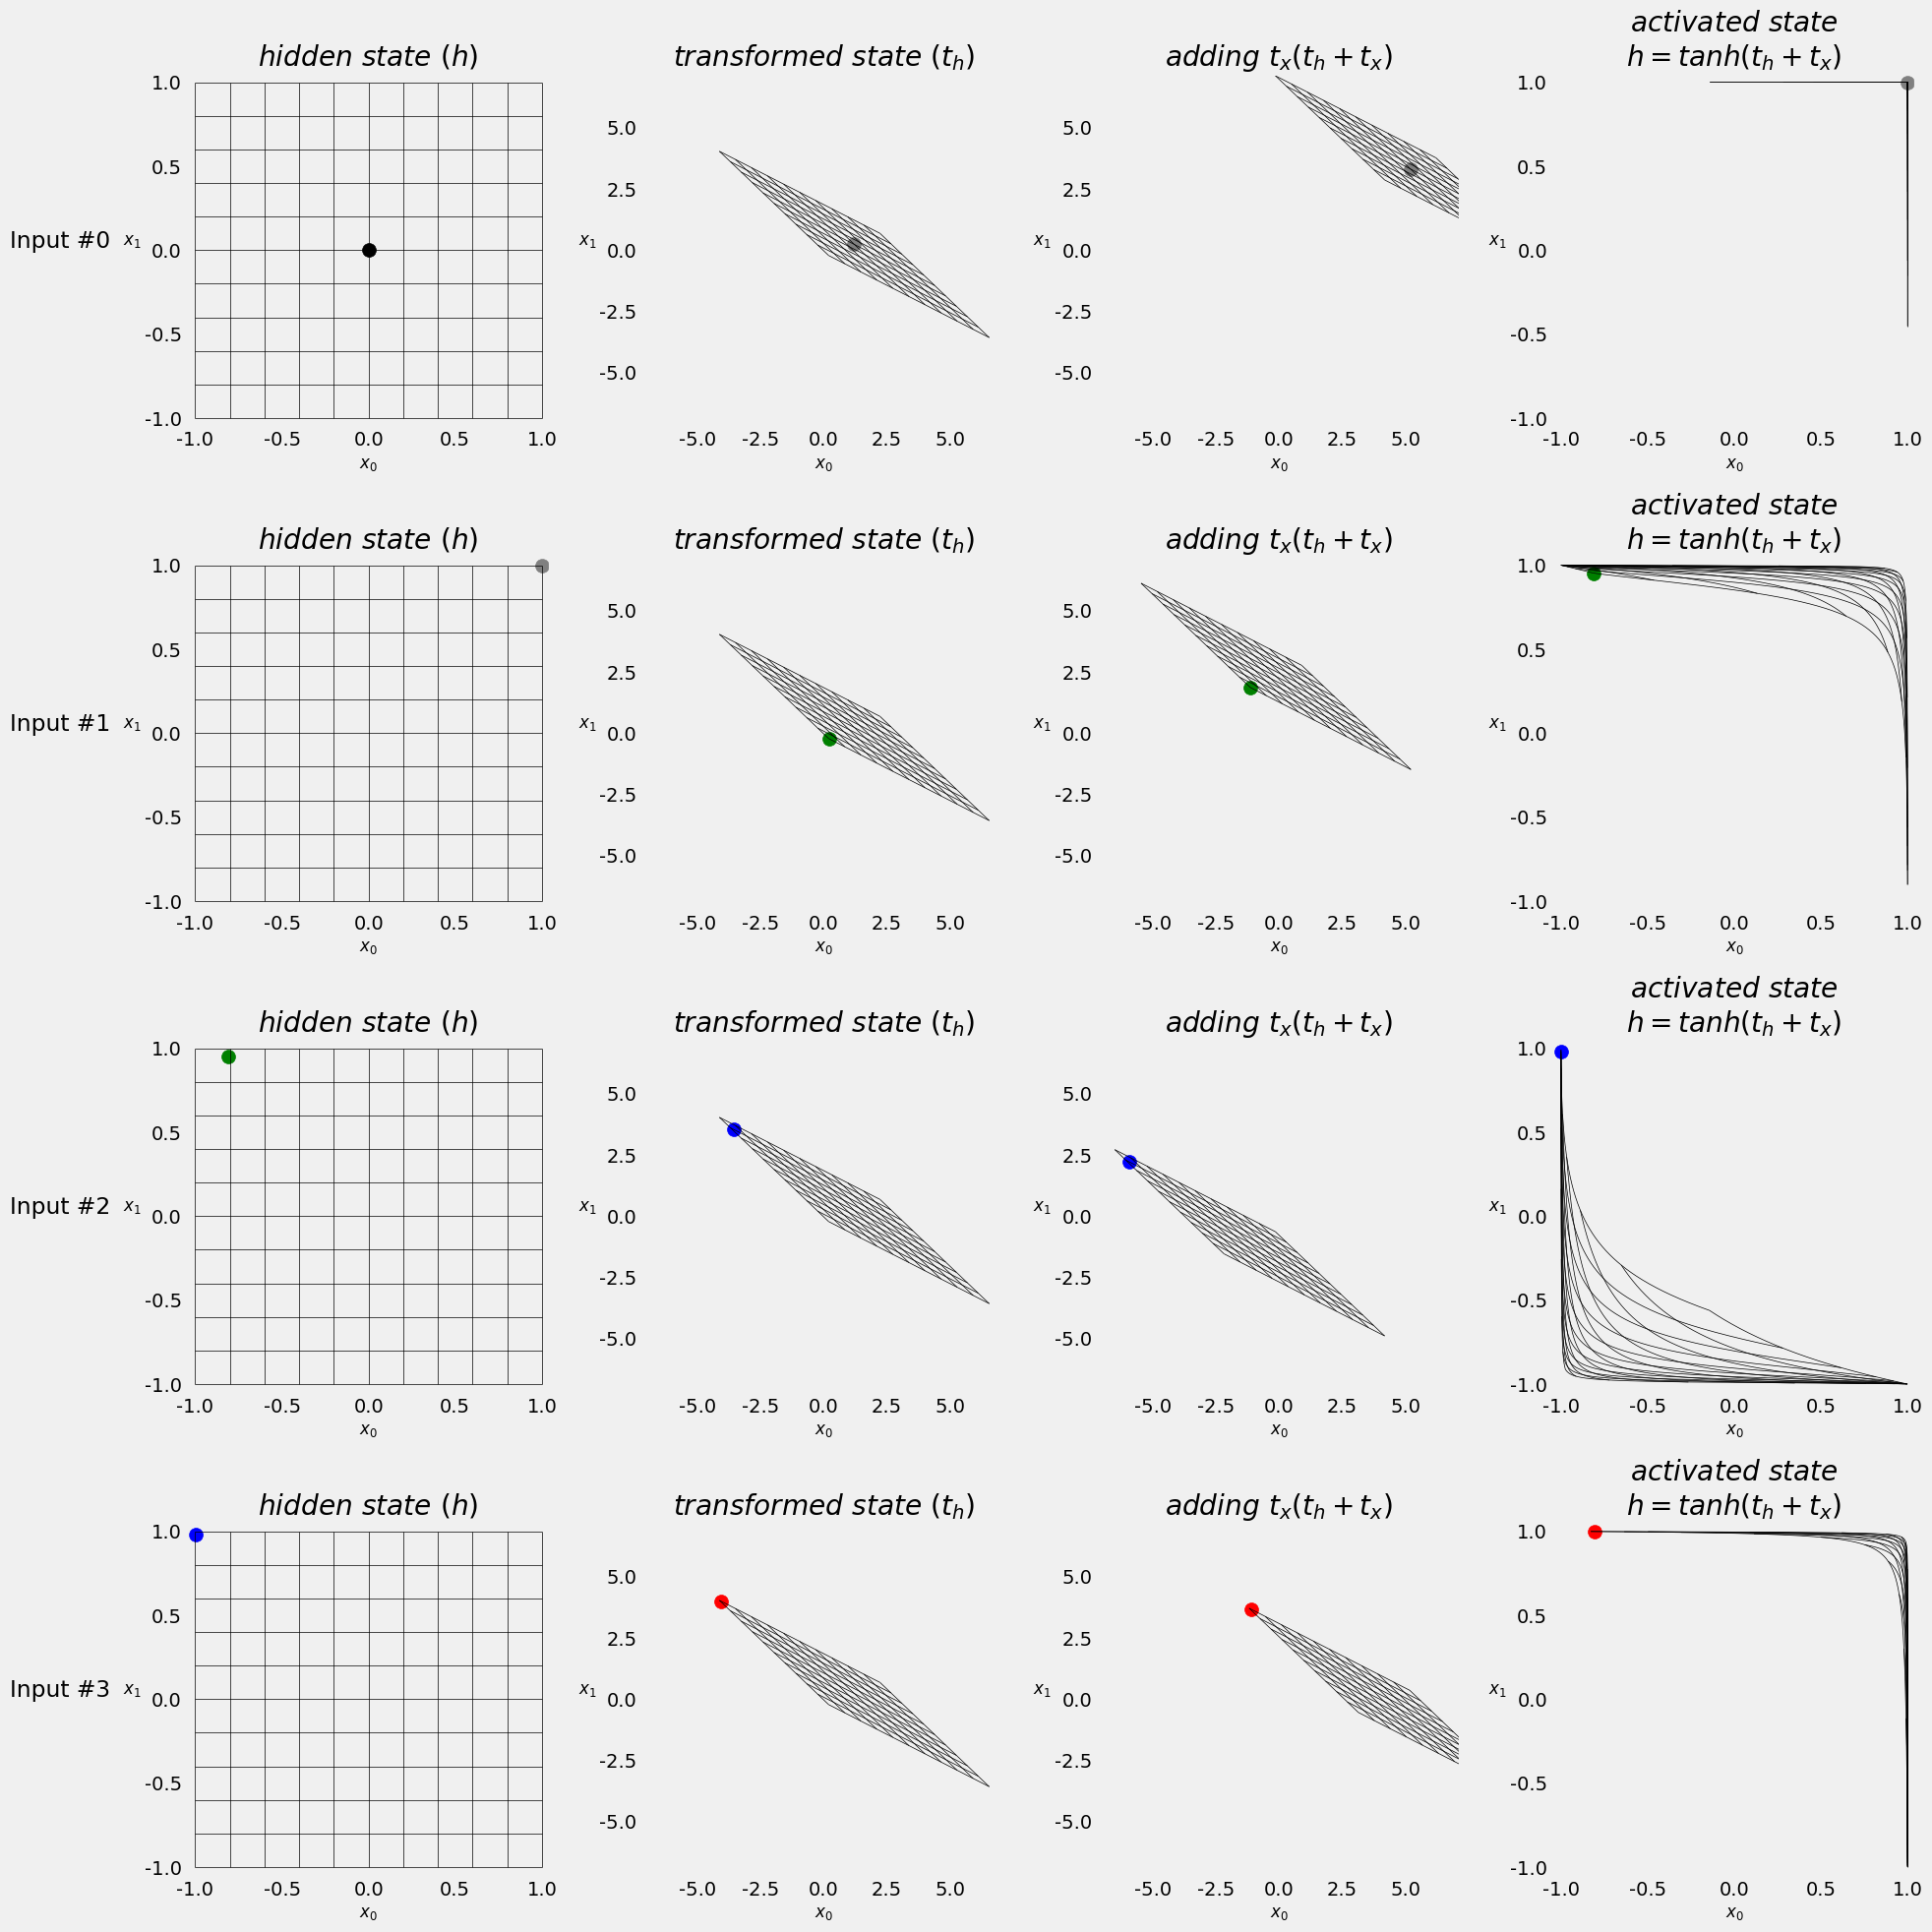

In [73]:
fig = figure16(model.basic_rnn)

In [74]:
square = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
model(square.to(sbs_rnn.device))
model.hidden

tensor([[[-0.8040,  0.9987]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>)

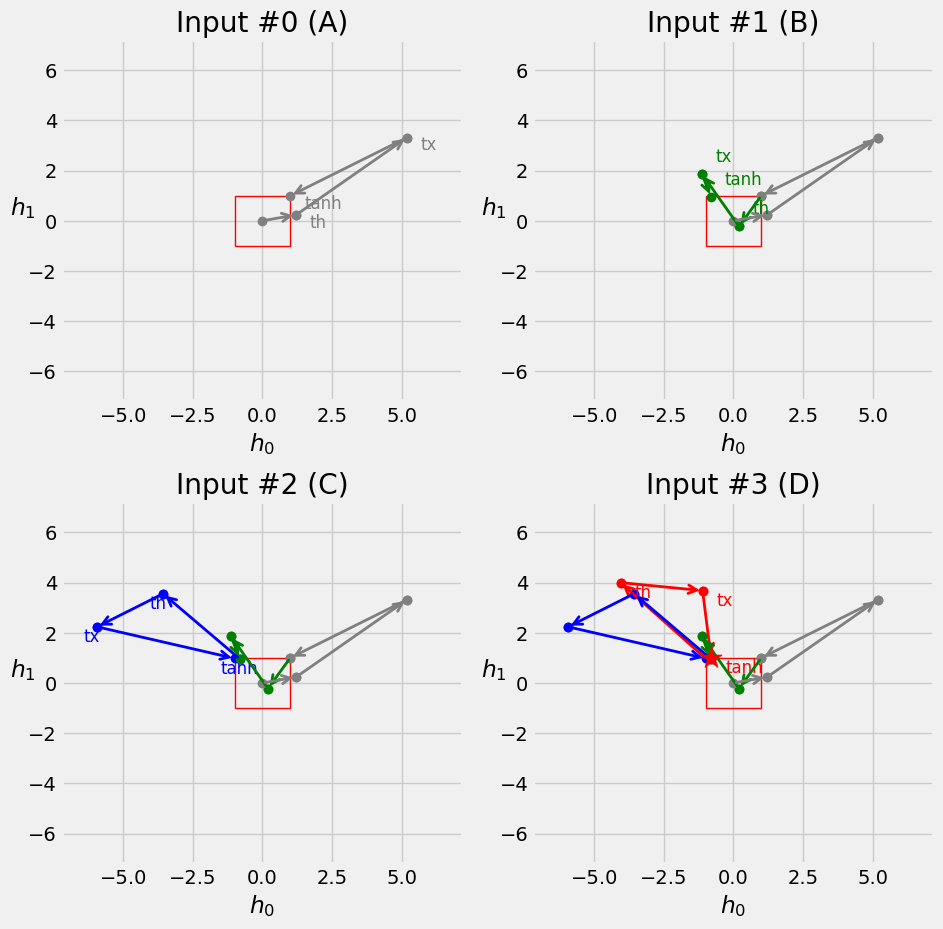

In [75]:
fig = figure17(model.basic_rnn)

## ***Gated Recurrent Units (GRUs)***

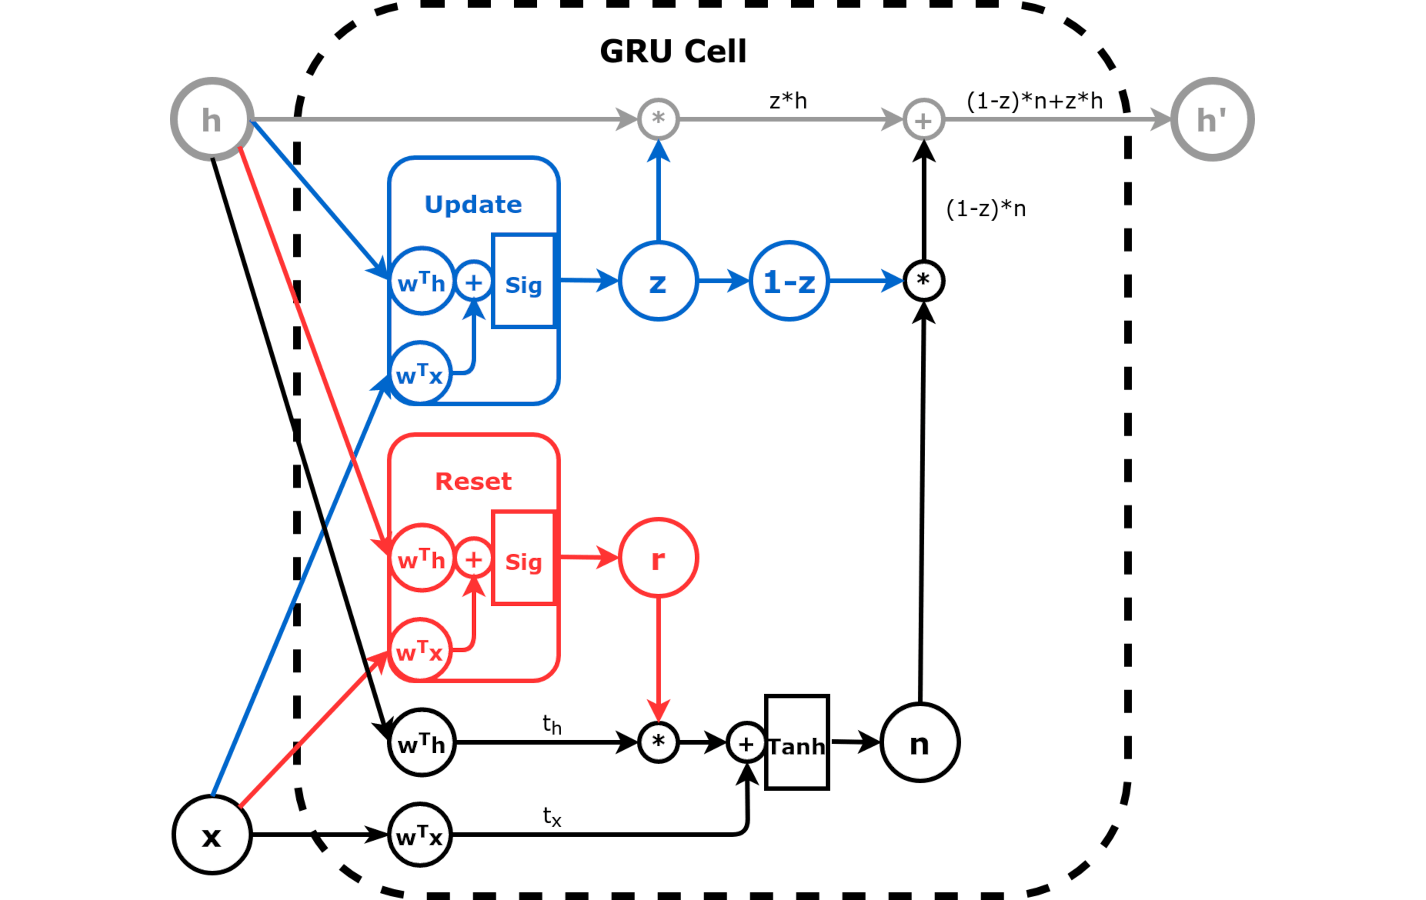

In [79]:
n_features = 2
hidden_dim = 2

torch.manual_seed(17)
gru_cell = nn.GRUCell(input_size=n_features, hidden_size=hidden_dim)
gru_state = gru_cell.state_dict()
gru_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889]])),
             ('weight_hh',
              tensor([[-0.4167, -0.4352],
                      [-0.2060, -0.3989],
                      [-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691]])),
             ('bias_ih',
              tensor([-0.4316,  0.4019,  0.1222, -0.4647, -0.5578,  0.4493])),
             ('bias_hh',
              tensor([-0.6800,  0.4422, -0.3559, -0.0279,  0.6553,  0.2918]))])

In [80]:
Wx, bx = gru_state['weight_ih'], gru_state['bias_ih']
Wh, bh = gru_state['weight_hh'], gru_state['bias_hh']

print(Wx.shape, Wh.shape)
print(bx.shape, bh.shape)

torch.Size([6, 2]) torch.Size([6, 2])
torch.Size([6]) torch.Size([6])


In [82]:
Wxr, Wxz, Wxn = Wx.split(hidden_dim, dim=0)
bxr, bxz, bxn = bx.split(hidden_dim, dim=0)

Whr, Whz, Whn = Wh.split(hidden_dim, dim=0)
bhr, bhz, bhn = bh.split(hidden_dim, dim=0)

Wxr, bxr

(tensor([[-0.0930,  0.0497],
         [ 0.4670, -0.5319]]),
 tensor([-0.4316,  0.4019]))

In [83]:
def linear_layers(Wx, bx, Wh, bh):
    hidden_dim, n_features = Wx.size()    
    lin_input = nn.Linear(n_features, hidden_dim)
    lin_input.load_state_dict({'weight': Wx, 'bias': bx})
    lin_hidden = nn.Linear(hidden_dim, hidden_dim)
    lin_hidden.load_state_dict({'weight': Wh, 'bias': bh})
    return lin_hidden, lin_input

r_hidden, r_input = linear_layers(Wxr, bxr, Whr, bhr) # reset gate - red
z_hidden, z_input = linear_layers(Wxz, bxz, Whz, bhz) # update gate - blue
n_hidden, n_input = linear_layers(Wxn, bxn, Whn, bhn) # candidate state - black

In [84]:
def reset_gate(h, x):
    thr = r_hidden(h)
    txr = r_input(x)
    r = torch.sigmoid(thr + txr)
    return r  # red
    
def update_gate(h, x):
    thz = z_hidden(h)
    txz = z_input(x)
    z = torch.sigmoid(thz + txz)
    return z  # blue
    
def candidate_n(h, x, r):
    thn = n_hidden(h)
    txn = n_input(x)
    n = torch.tanh(r * thn + txn)
    return n  # black

In [85]:
initial_hidden = torch.zeros(1, hidden_dim)
X = torch.as_tensor(points[0]).float()
first_corner = X[0:1]

In [86]:
r = reset_gate(initial_hidden, first_corner)
r

tensor([[0.2387, 0.6928]], grad_fn=<SigmoidBackward0>)

In [87]:
n = candidate_n(initial_hidden, first_corner, r)
n

tensor([[-0.8032, -0.2275]], grad_fn=<TanhBackward0>)

In [88]:
z = update_gate(initial_hidden, first_corner)
z

tensor([[0.2984, 0.3540]], grad_fn=<SigmoidBackward0>)

In [89]:
h_prime = n*(1-z) + initial_hidden*z
h_prime

tensor([[-0.5635, -0.1470]], grad_fn=<AddBackward0>)

In [90]:
gru_cell(first_corner)

tensor([[-0.5635, -0.1470]], grad_fn=<AddBackward0>)

## ***GRU Layer****

## ***Square Model II: The Quickening***

In [91]:
class SquareModelGRU(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None

        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

    def forward(self, x):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        batch_first_output, self.hidden = self.basic_rnn(x)
        
        # (N, 1, H)
        last_output = batch_first_output[:, -1]
        
        # (N, 1, n_outputs)
        out = self.classifier(last_output)
        
        # (N, n_outputs)
        out = out.view(-1, self.n_outputs)
        
        return out

In [92]:
torch.manual_seed(21)
model = SquareModelGRU(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [93]:
sbs_gru = StepByStep(model, loss, optimizer)
sbs_gru.set_loaders(train_loader, test_loader)
sbs_gru.train(100)

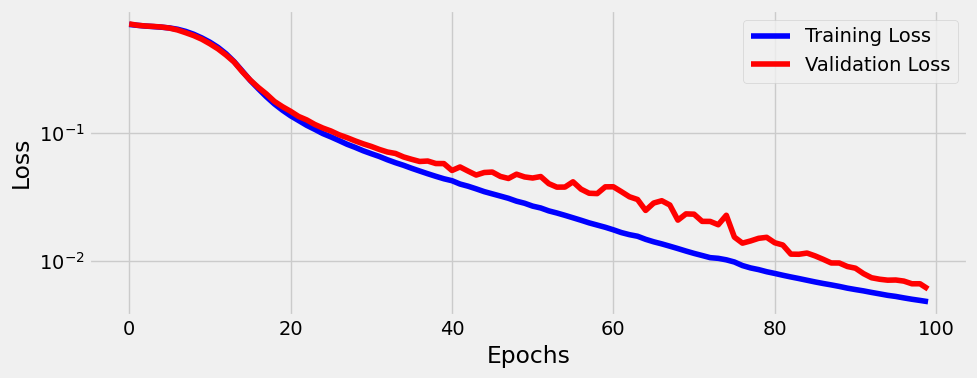

In [94]:
fig = sbs_gru.plot_losses()

In [95]:
StepByStep.loader_apply(test_loader, sbs_gru.correct)

tensor([[53, 53],
        [75, 75]])

/usr/local/Huangshuqi/jupterCode/PytorchCode/SequenceData/plots.py:336: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


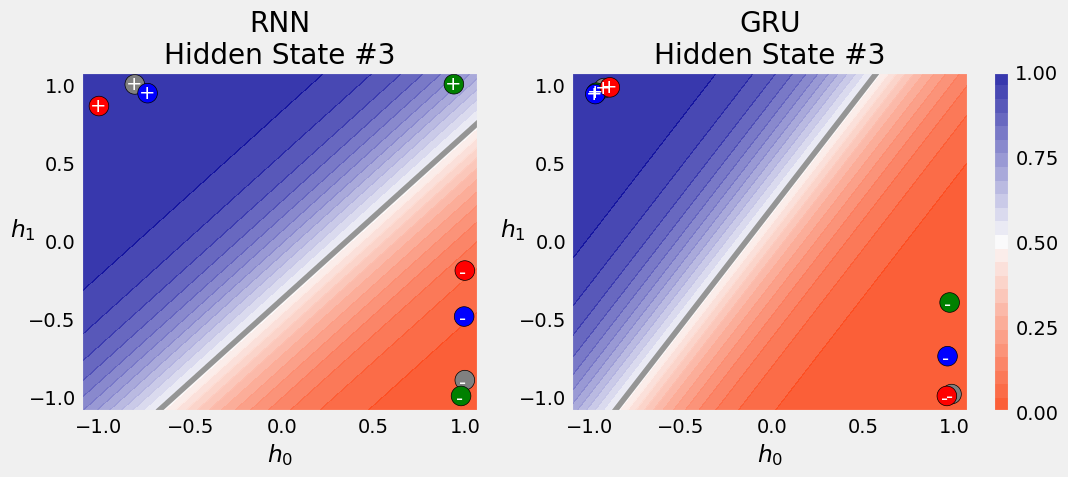

In [96]:
fig = figure20(sbs_rnn.model, sbs_gru.model)

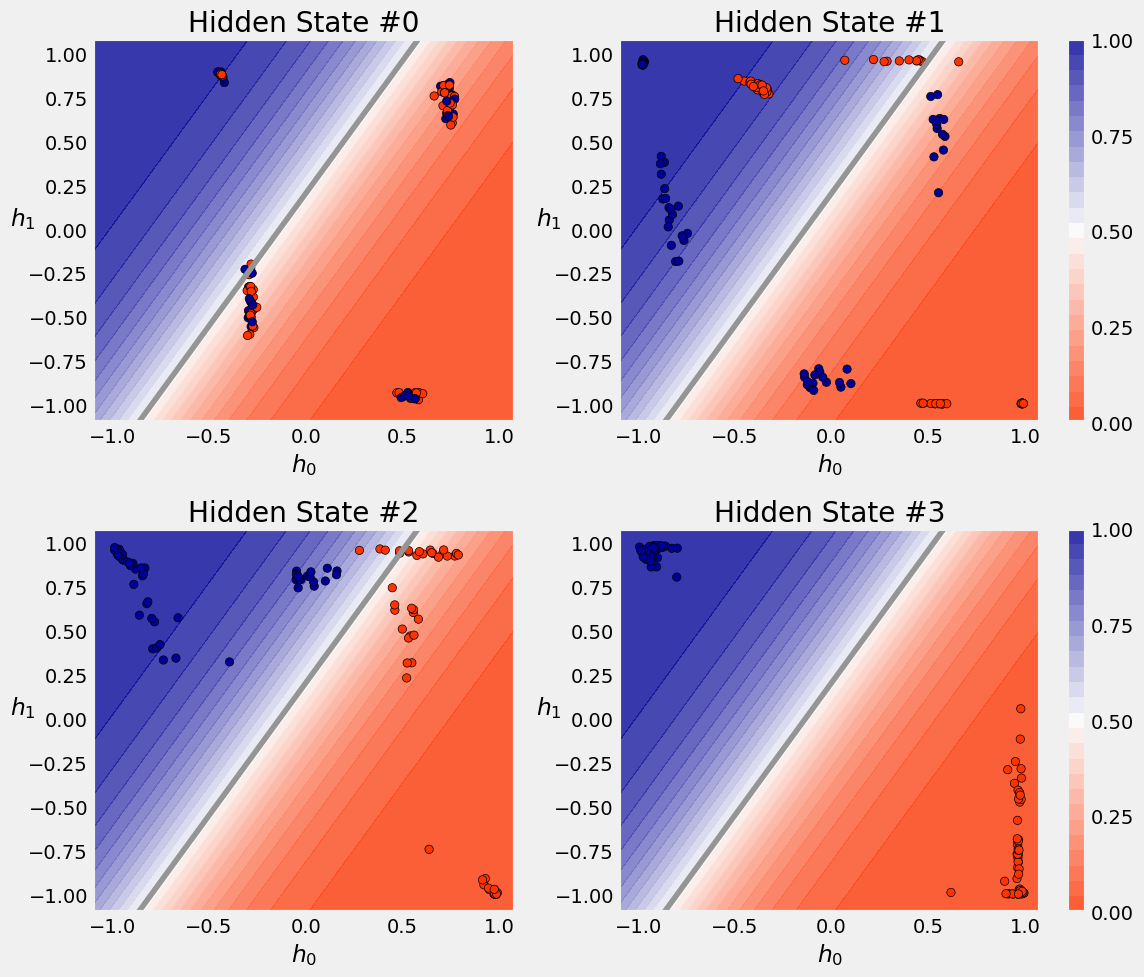

In [97]:
fig = hidden_states_contour(model, points, directions)

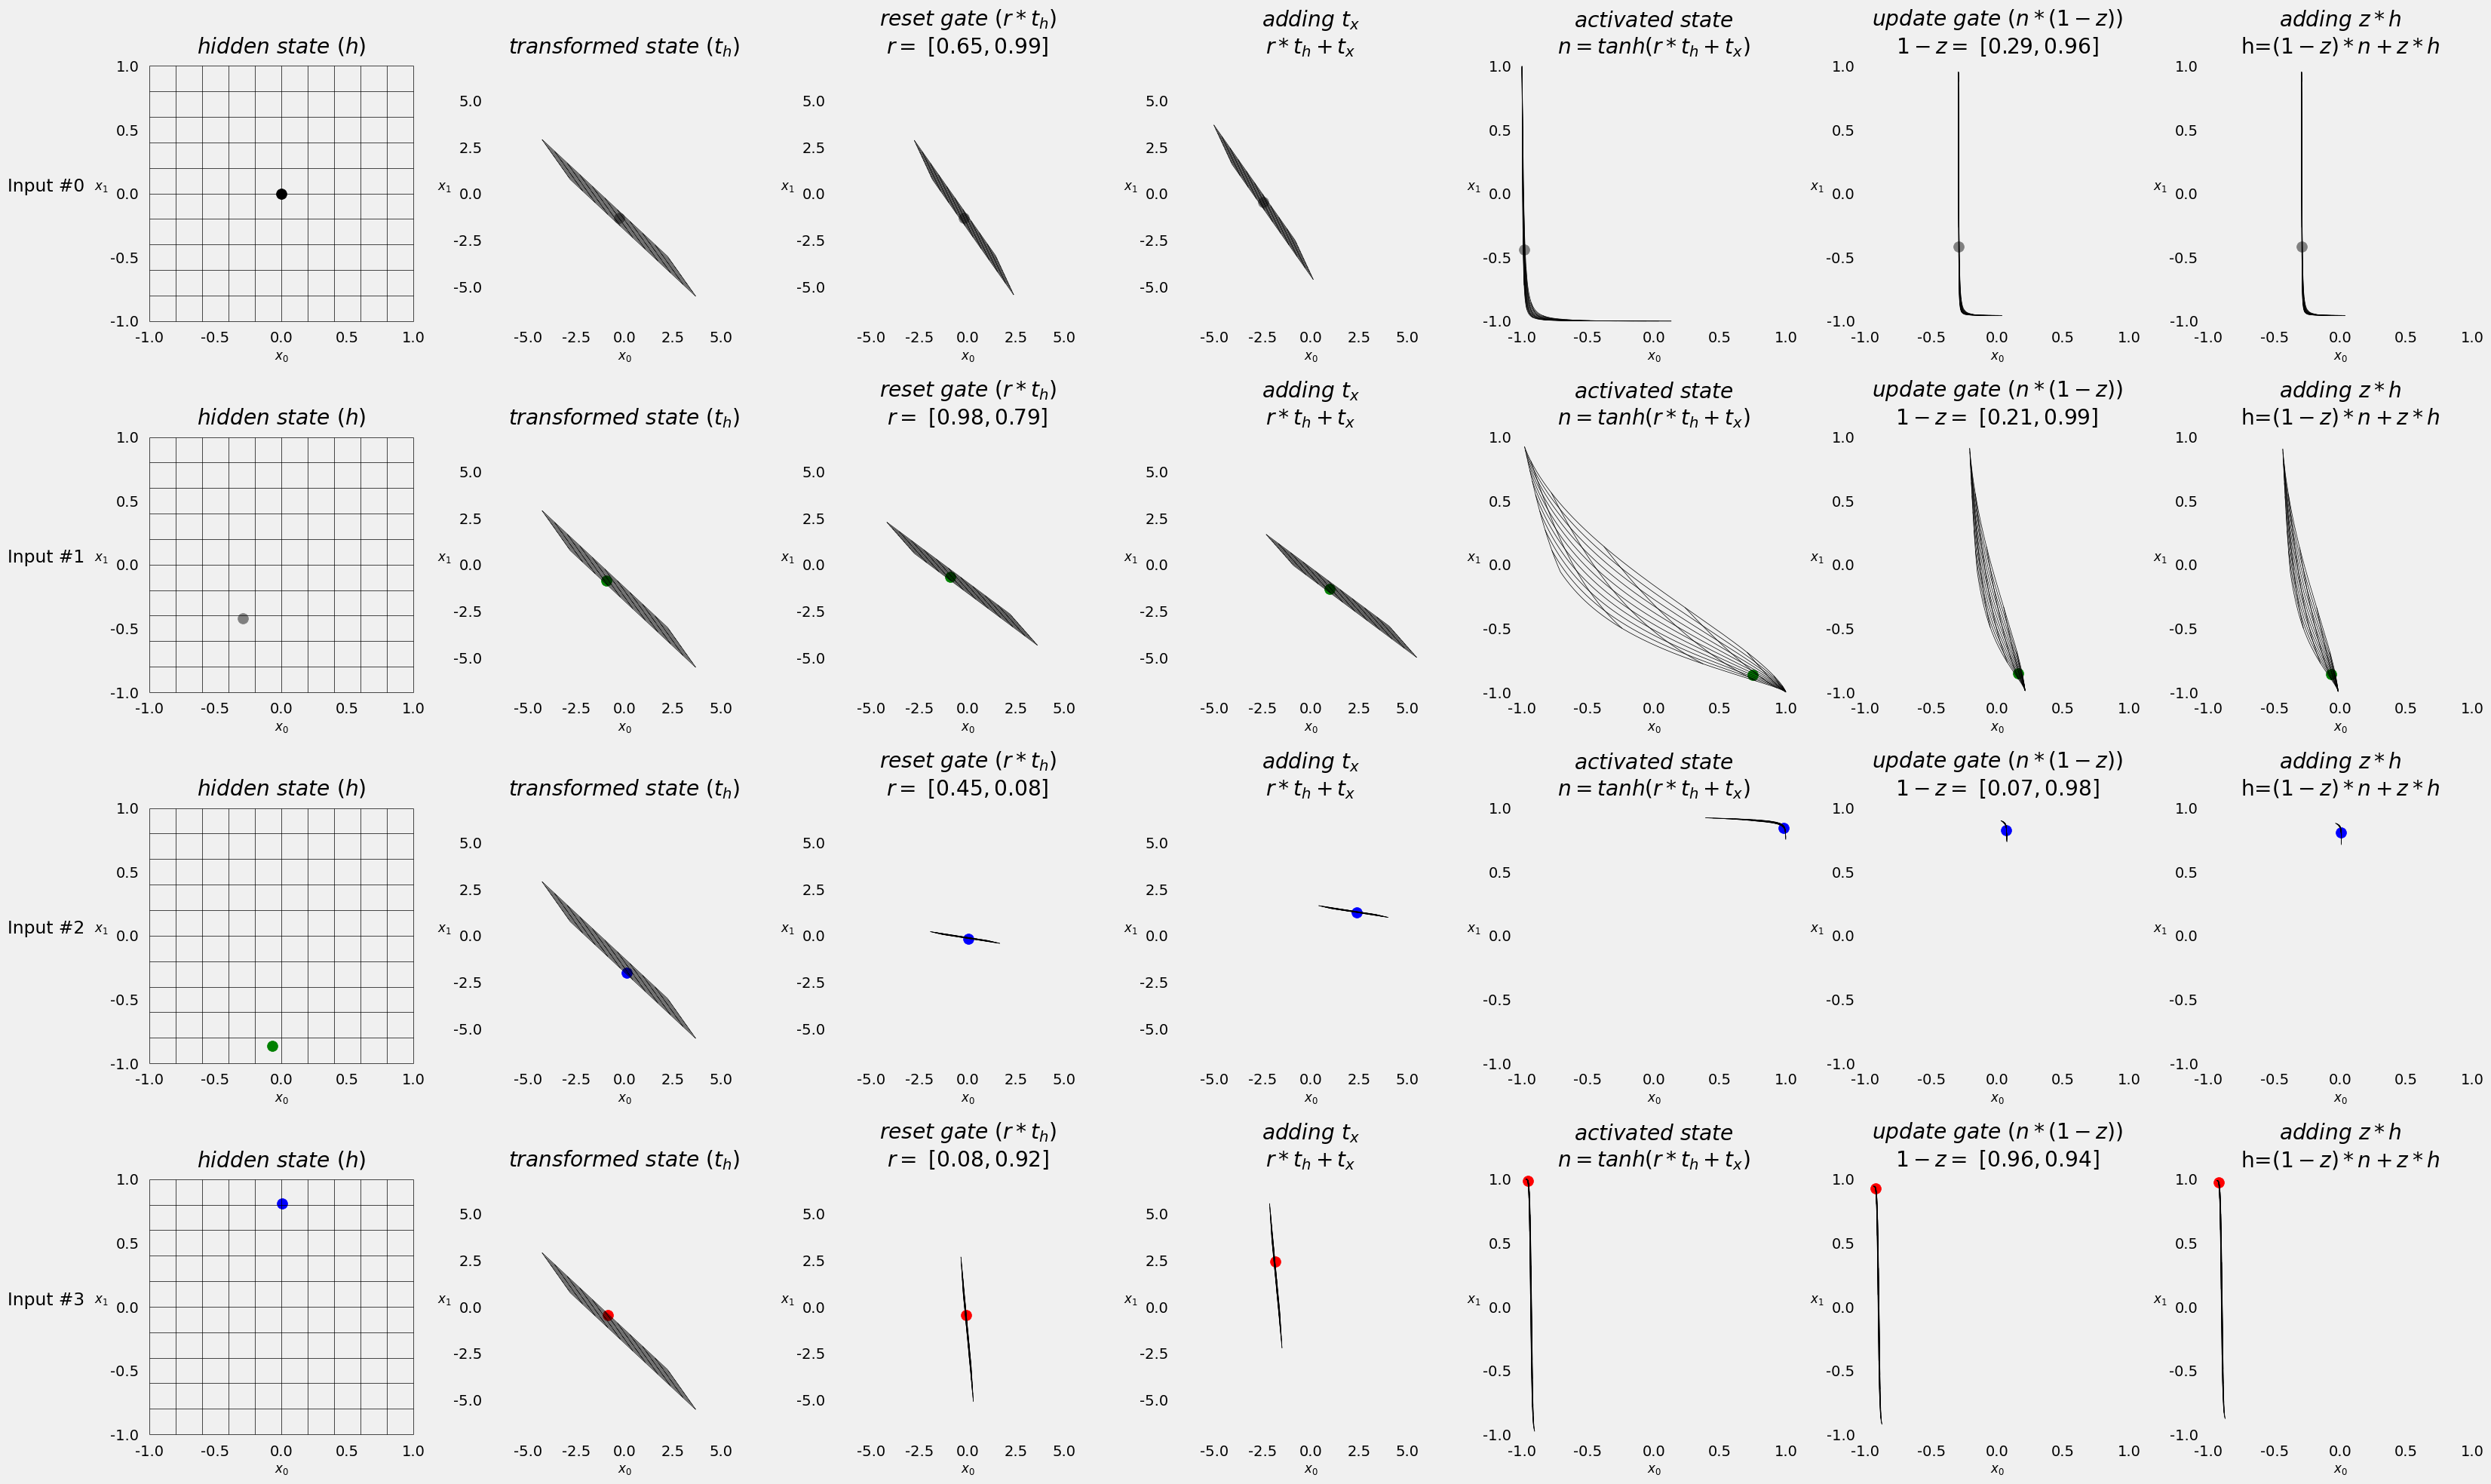

In [98]:
fig = figure22(model.basic_rnn)

## ***Long Short-Term Memory (LSTM)***

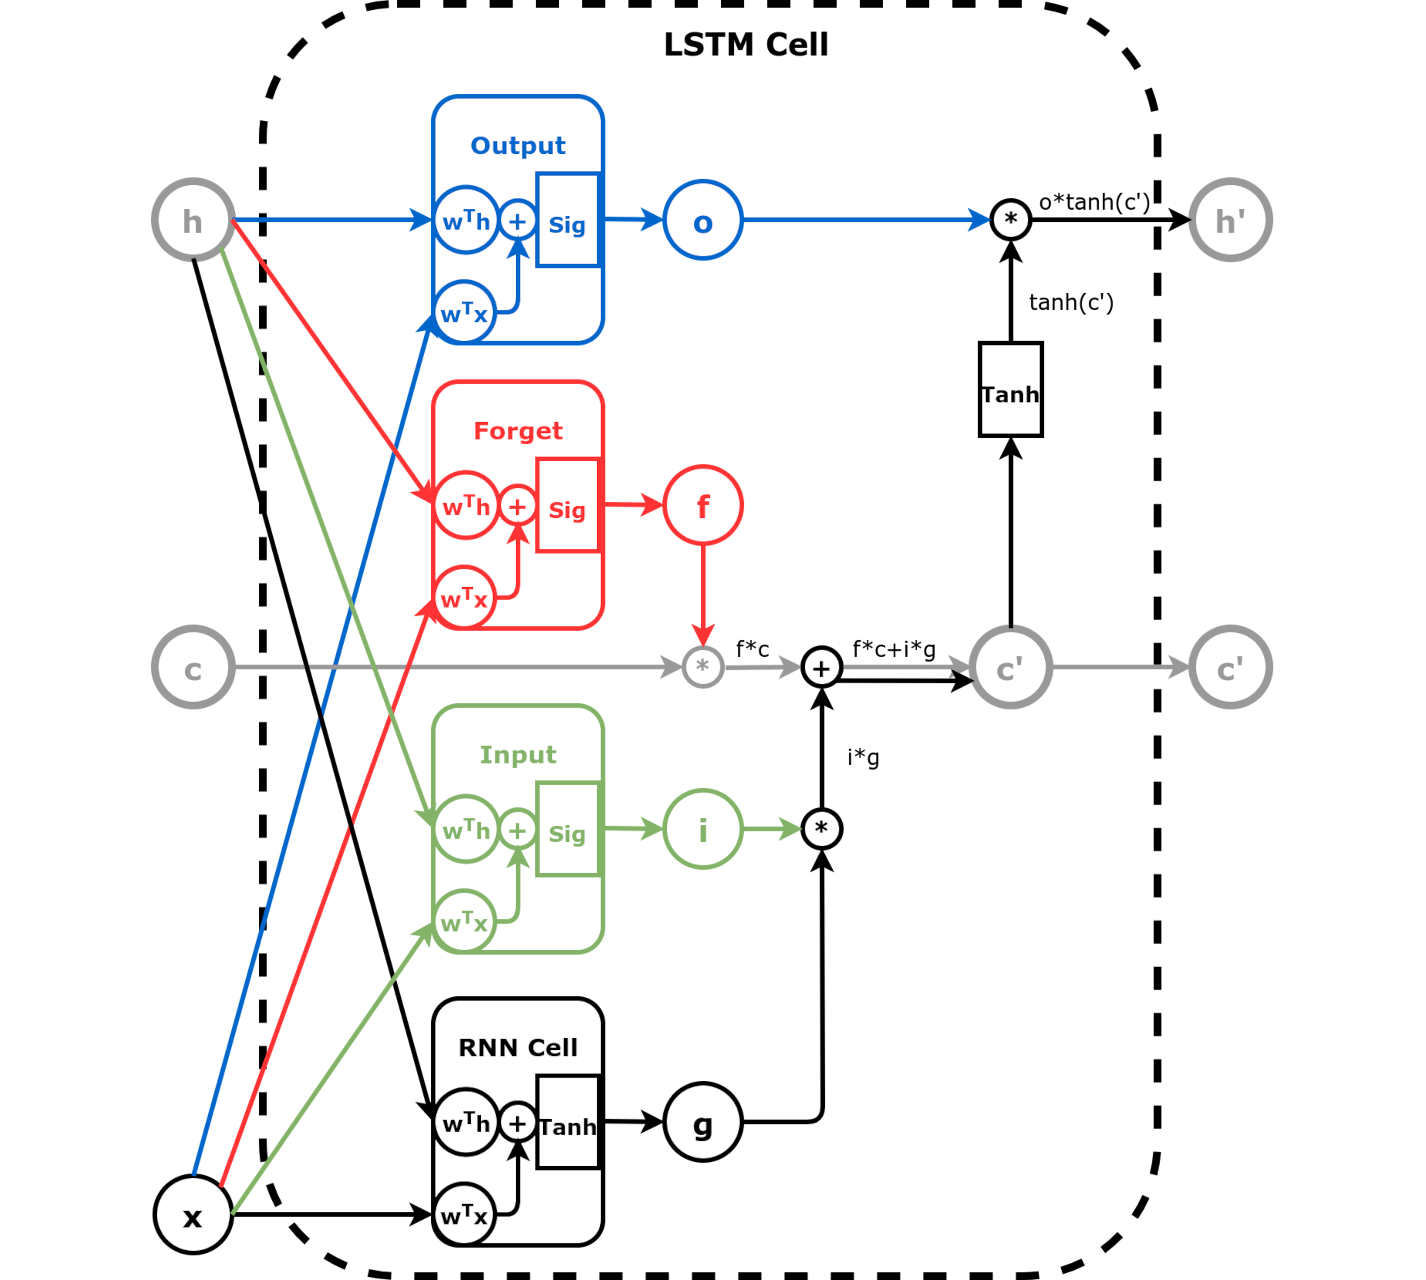

In [99]:
n_features = 2
hidden_dim = 2

torch.manual_seed(17)
lstm_cell = nn.LSTMCell(input_size=n_features, hidden_size=hidden_dim)
lstm_state = lstm_cell.state_dict()
lstm_state

OrderedDict([('weight_ih',
              tensor([[-0.0930,  0.0497],
                      [ 0.4670, -0.5319],
                      [-0.6656,  0.0699],
                      [-0.1662,  0.0654],
                      [-0.0449, -0.6828],
                      [-0.6769, -0.1889],
                      [-0.4167, -0.4352],
                      [-0.2060, -0.3989]])),
             ('weight_hh',
              tensor([[-0.7070, -0.5083],
                      [ 0.1418,  0.0930],
                      [-0.5729, -0.5700],
                      [-0.1818, -0.6691],
                      [-0.4316,  0.4019],
                      [ 0.1222, -0.4647],
                      [-0.5578,  0.4493],
                      [-0.6800,  0.4422]])),
             ('bias_ih',
              tensor([-0.3559, -0.0279,  0.6553,  0.2918,  0.4007,  0.3262, -0.0778, -0.3002])),
             ('bias_hh',
              tensor([-0.3991, -0.3200,  0.3483, -0.2604, -0.1582,  0.5558,  0.5761, -0.3919]))])

In [100]:
Wx, bx = lstm_state['weight_ih'], lstm_state['bias_ih']
Wh, bh = lstm_state['weight_hh'], lstm_state['bias_hh']

# Split weights and biases for data points
Wxi, Wxf, Wxg, Wxo = Wx.split(hidden_dim, dim=0)
bxi, bxf, bxg, bxo = bx.split(hidden_dim, dim=0)
# Split weights and biases for hidden state
Whi, Whf, Whg, Who = Wh.split(hidden_dim, dim=0)
bhi, bhf, bhg, bho = bh.split(hidden_dim, dim=0)

# Creates linear layers for the components
i_hidden, i_input = linear_layers(Wxi, bxi, Whi, bhi) # input gate - green
f_hidden, f_input = linear_layers(Wxf, bxf, Whf, bhf) # forget gate - red
o_hidden, o_input = linear_layers(Wxo, bxo, Who, bho) # output gate - blue

In [101]:
g_cell = nn.RNNCell(n_features, hidden_dim) # black
g_cell.load_state_dict({'weight_ih': Wxg, 'bias_ih': bxg,
                        'weight_hh': Whg, 'bias_hh': bhg})

<All keys matched successfully>

In [102]:
def forget_gate(h, x):
    thf = f_hidden(h)
    txf = f_input(x)
    f = torch.sigmoid(thf + txf)
    return f  # red
    
def output_gate(h, x):
    tho = o_hidden(h)
    txo = o_input(x)
    o = torch.sigmoid(tho + txo)
    return o  # blue

def input_gate(h, x):
    thi = i_hidden(h)
    txi = i_input(x)
    i = torch.sigmoid(thi + txi)
    return i  # green

In [103]:
initial_hidden = torch.zeros(1, hidden_dim)
initial_cell = torch.zeros(1, hidden_dim)

X = torch.as_tensor(points[0]).float()
first_corner = X[0:1]

In [104]:
g = g_cell(first_corner)
i = input_gate(initial_hidden, first_corner)
gated_input = g * i
gated_input

tensor([[-0.1340, -0.0004]], grad_fn=<MulBackward0>)

In [105]:
f = forget_gate(initial_hidden, first_corner)
gated_cell = initial_cell * f
gated_cell

tensor([[0., 0.]], grad_fn=<MulBackward0>)

In [106]:
c_prime = gated_cell + gated_input
c_prime

tensor([[-0.1340, -0.0004]], grad_fn=<AddBackward0>)

In [107]:
o = output_gate(initial_hidden, first_corner)
h_prime = o * torch.tanh(c_prime)
h_prime

tensor([[-5.4936e-02, -8.3816e-05]], grad_fn=<MulBackward0>)

In [108]:
(h_prime, c_prime)

(tensor([[-5.4936e-02, -8.3816e-05]], grad_fn=<MulBackward0>),
 tensor([[-0.1340, -0.0004]], grad_fn=<AddBackward0>))

In [109]:
lstm_cell(first_corner)

(tensor([[-5.4936e-02, -8.3816e-05]], grad_fn=<MulBackward0>),
 tensor([[-0.1340, -0.0004]], grad_fn=<AddBackward0>))

### ***LSTM Layer***

In [114]:
class SquareModelLSTM(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, batch_first=True) 
        # Classifier to produce as many logits as outputs        
        self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)
                
    def forward(self, X):
        # X is batch first (N, L, F)
        # output is (N, L, H)
        # final hidden state is (1, N, H)
        # final cell state is (1, N, H)
        batch_first_output, (self.hidden, self.cell) = self.basic_rnn(X)
        
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[:, -1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)

        out = out.view(-1, self.n_outputs)
        # final output is (N, n_outputs)
        return out

In [115]:
torch.manual_seed(21)
model = SquareModelLSTM(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [116]:
sbs_lstm = StepByStep(model, loss, optimizer)
sbs_lstm.set_loaders(train_loader, test_loader)
sbs_lstm.train(100)

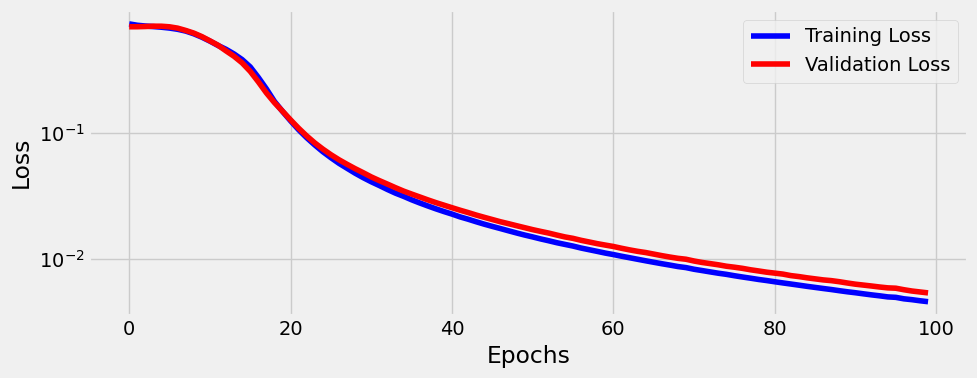

In [117]:
fig = sbs_lstm.plot_losses()

In [118]:
StepByStep.loader_apply(test_loader, sbs_lstm.correct)

tensor([[53, 53],
        [75, 75]])

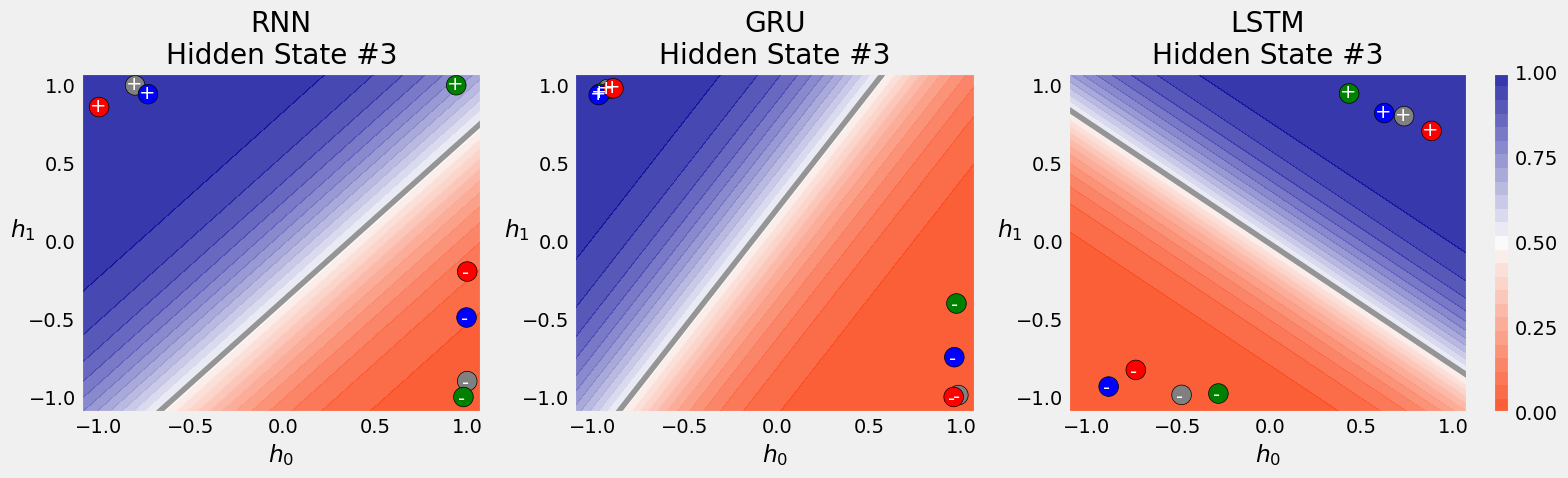

In [119]:
fig = figure25(sbs_rnn.model, sbs_gru.model, sbs_lstm.model)

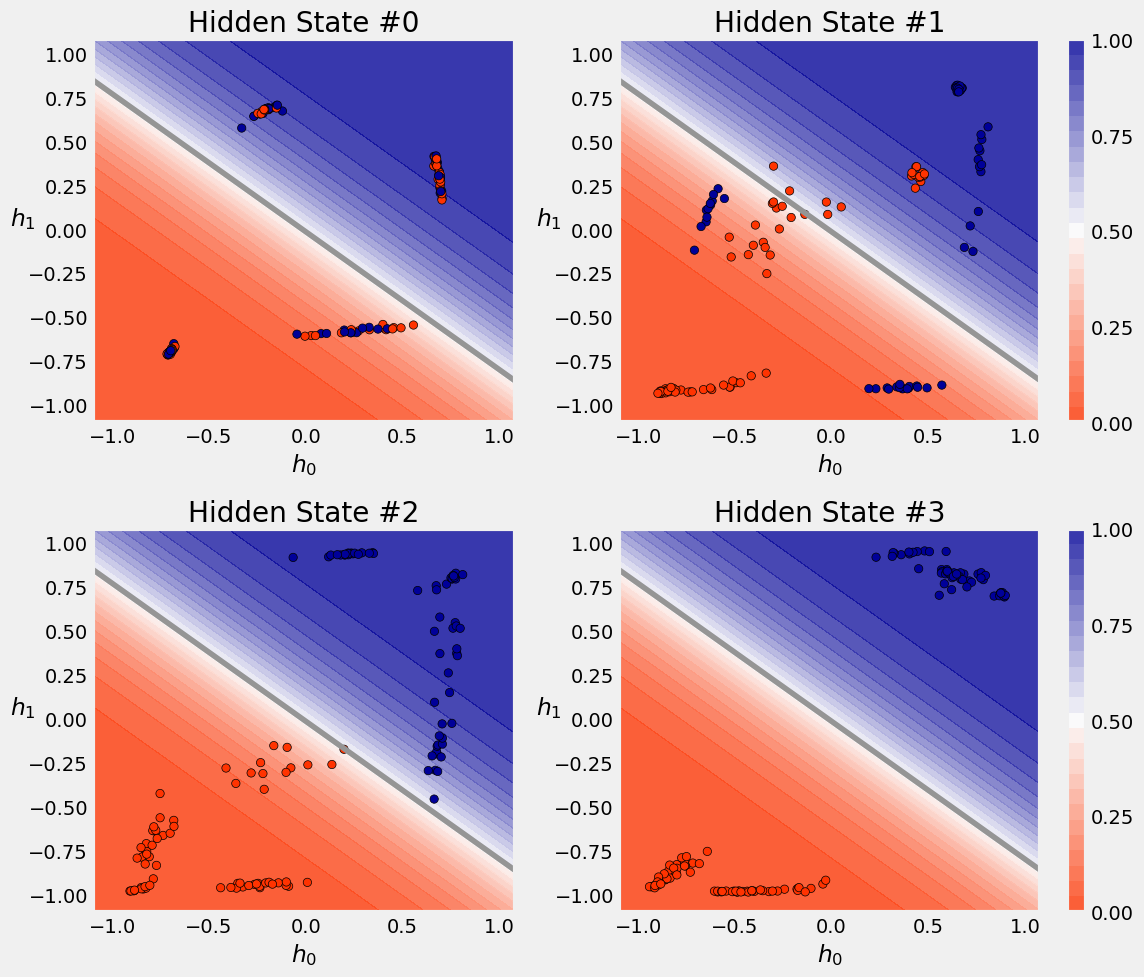

In [120]:
fig = hidden_states_contour(model, points, directions)

In [121]:
s0 = points[0]      # 4 data points
s1 = points[1][2:]  # 2 data points
s2 = points[2][1:]  # 3 data points

s0.shape, s1.shape, s2.shape

((4, 2), (2, 2), (3, 2))

### ***Padding***

In [122]:
all_seqs = [s0, s1, s2]
torch.as_tensor(all_seqs)

ValueError: expected sequence of length 4 at dim 1 (got 2)

In [123]:
seq_tensors = [torch.as_tensor(seq).float() for seq in all_seqs]
padded = rnn_utils.pad_sequence(seq_tensors, batch_first=True)
padded

tensor([[[ 1.0349,  0.9661],
         [ 0.8055, -0.9169],
         [-0.8251, -0.9499],
         [-0.8670,  0.9342]],

        [[-1.0911,  0.9254],
         [-1.0771, -1.0414],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000]],

        [[-1.1247, -0.9683],
         [ 0.8182, -0.9944],
         [ 1.0081,  0.7680],
         [ 0.0000,  0.0000]]])

In [124]:
torch.manual_seed(11)
rnn = nn.RNN(2, 2, batch_first=True)

In [125]:
output_padded, hidden_padded = rnn(padded)
output_padded

tensor([[[-0.6388,  0.8505],
         [-0.4215,  0.8979],
         [ 0.3792,  0.3432],
         [ 0.3161, -0.1675]],

        [[ 0.2911, -0.1811],
         [ 0.3051,  0.7055],
         [ 0.0052,  0.5819],
         [-0.0642,  0.6012]],

        [[ 0.3385,  0.5927],
         [-0.3875,  0.9422],
         [-0.4832,  0.6595],
         [-0.1007,  0.5349]]], grad_fn=<TransposeBackward1>)

In [126]:
hidden_padded.permute(1, 0, 2)

tensor([[[ 0.3161, -0.1675]],

        [[-0.0642,  0.6012]],

        [[-0.1007,  0.5349]]], grad_fn=<PermuteBackward0>)

### ***Packing***

In [127]:
packed = rnn_utils.pack_sequence(seq_tensors, enforce_sorted=False)
packed

PackedSequence(data=tensor([[ 1.0349,  0.9661],
        [-1.1247, -0.9683],
        [-1.0911,  0.9254],
        [ 0.8055, -0.9169],
        [ 0.8182, -0.9944],
        [-1.0771, -1.0414],
        [-0.8251, -0.9499],
        [ 1.0081,  0.7680],
        [-0.8670,  0.9342]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

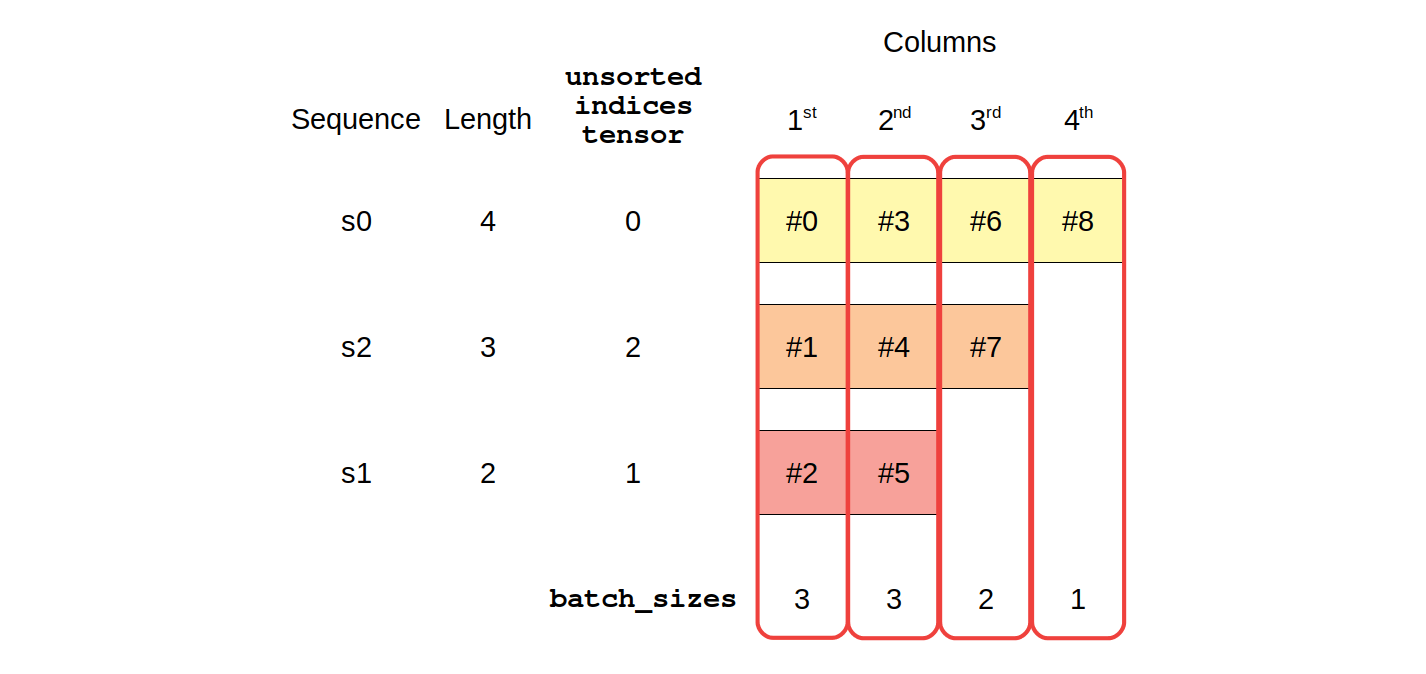

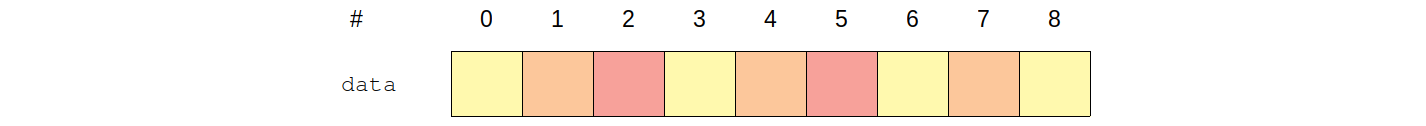

In [128]:
(packed.data[[0, 3, 6, 8]] == seq_tensors[0]).all()

tensor(True)

In [129]:
output_packed, hidden_packed = rnn(packed)
output_packed, hidden_packed

(PackedSequence(data=tensor([[-0.6388,  0.8505],
         [ 0.3385,  0.5927],
         [ 0.2911, -0.1811],
         [-0.4215,  0.8979],
         [-0.3875,  0.9422],
         [ 0.3051,  0.7055],
         [ 0.3792,  0.3432],
         [-0.4832,  0.6595],
         [ 0.3161, -0.1675]], grad_fn=<CatBackward0>), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1])),
 tensor([[[ 0.3161, -0.1675],
          [ 0.3051,  0.7055],
          [-0.4832,  0.6595]]], grad_fn=<IndexSelectBackward0>))

In [130]:
hidden_packed == hidden_padded

tensor([[[ True,  True],
         [False, False],
         [False, False]]])

In [131]:
output_packed.data[[2, 5]] # x1 sequence

tensor([[ 0.2911, -0.1811],
        [ 0.3051,  0.7055]], grad_fn=<IndexBackward0>)

### ***Unpacking (to padded)***

In [132]:
output_unpacked, seq_sizes = rnn_utils.pad_packed_sequence(output_packed, batch_first=True)
output_unpacked, seq_sizes

(tensor([[[-0.6388,  0.8505],
          [-0.4215,  0.8979],
          [ 0.3792,  0.3432],
          [ 0.3161, -0.1675]],
 
         [[ 0.2911, -0.1811],
          [ 0.3051,  0.7055],
          [ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],
 
         [[ 0.3385,  0.5927],
          [-0.3875,  0.9422],
          [-0.4832,  0.6595],
          [ 0.0000,  0.0000]]], grad_fn=<IndexSelectBackward0>),
 tensor([4, 2, 3]))

In [133]:
output_unpacked[:, -1]

tensor([[ 0.3161, -0.1675],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]], grad_fn=<SelectBackward0>)

In [134]:
seq_idx = torch.arange(seq_sizes.size(0))
output_unpacked[seq_idx, seq_sizes-1]

tensor([[ 0.3161, -0.1675],
        [ 0.3051,  0.7055],
        [-0.4832,  0.6595]], grad_fn=<IndexBackward0>)

### ***Packing (from padded)***

In [135]:
len_seqs = [len(seq) for seq in all_seqs]
len_seqs

[4, 2, 3]

In [136]:
packed = rnn_utils.pack_padded_sequence(padded, len_seqs, enforce_sorted=False, batch_first=True)
packed

PackedSequence(data=tensor([[ 1.0349,  0.9661],
        [-1.1247, -0.9683],
        [-1.0911,  0.9254],
        [ 0.8055, -0.9169],
        [ 0.8182, -0.9944],
        [-1.0771, -1.0414],
        [-0.8251, -0.9499],
        [ 1.0081,  0.7680],
        [-0.8670,  0.9342]]), batch_sizes=tensor([3, 3, 2, 1]), sorted_indices=tensor([0, 2, 1]), unsorted_indices=tensor([0, 2, 1]))

### ***Variable-Length Dataset***

In [137]:
var_points, var_directions = generate_sequences(variable_len=True)
var_points[:2]

[array([[ 1.12636495,  1.1570899 ],
        [ 0.87384513, -1.00750892],
        [-0.9149893 , -1.09150317],
        [-1.0867348 ,  1.07731667]]),
 array([[ 0.92250954, -0.89887678],
        [ 1.0941646 ,  0.92300589]])]

### ***Data Preparation***

In [138]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = [torch.as_tensor(s).float() for s in x]
        self.y = torch.as_tensor(y).float().view(-1, 1)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    
train_var_data = CustomDataset(var_points, var_directions)

In [141]:
def pack_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_pack = rnn_utils.pack_sequence(X, enforce_sorted=False)

    return X_pack, torch.as_tensor(y).view(-1, 1)

In [142]:
# list of tuples returned by the dataset
dummy_batch = [train_var_data[0], train_var_data[1]]
dummy_x, dummy_y = pack_collate(dummy_batch)
dummy_x

PackedSequence(data=tensor([[ 1.1264,  1.1571],
        [ 0.9225, -0.8989],
        [ 0.8738, -1.0075],
        [ 1.0942,  0.9230],
        [-0.9150, -1.0915],
        [-1.0867,  1.0773]]), batch_sizes=tensor([2, 2, 1, 1]), sorted_indices=tensor([0, 1]), unsorted_indices=tensor([0, 1]))

In [143]:
train_var_loader = DataLoader(train_var_data, batch_size=16, shuffle=True, collate_fn=pack_collate)

In [146]:
x_batch, y_batch = next(iter(train_var_loader))

In [149]:
class SquareModelPacked(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs):
        super(SquareModelPacked, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        # Simple LSTM
        self.basic_rnn = nn.LSTM(self.n_features, self.hidden_dim, bidirectional=True) 
        # Classifier to produce as many logits as outputs        
        self.classifier = nn.Linear(2 * self.hidden_dim, self.n_outputs)

    def forward(self, X):       
        # X is a PACKED sequence now
        
        # output is PACKED
        # final hidden state is (2, N, H) - bidirectional
        # final cell state is (2, N, H) - bidirectional
        rnn_out, (self.hidden, self.cell) = self.basic_rnn(X)
        
        # unpack the output (N, L, 2*H)
        batch_first_output, seq_sizes = rnn_utils.pad_packed_sequence(rnn_out, batch_first=True)
        
        # only last item in sequence (N, 1, 2*H)
        seq_idx = torch.arange(seq_sizes.size(0))
        
        last_output = batch_first_output[seq_idx, seq_sizes-1]
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
                
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [150]:
torch.manual_seed(21)
model = SquareModelPacked(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [151]:
sbs_packed = StepByStep(model, loss, optimizer)
sbs_packed.set_loaders(train_var_loader)
sbs_packed.train(100)

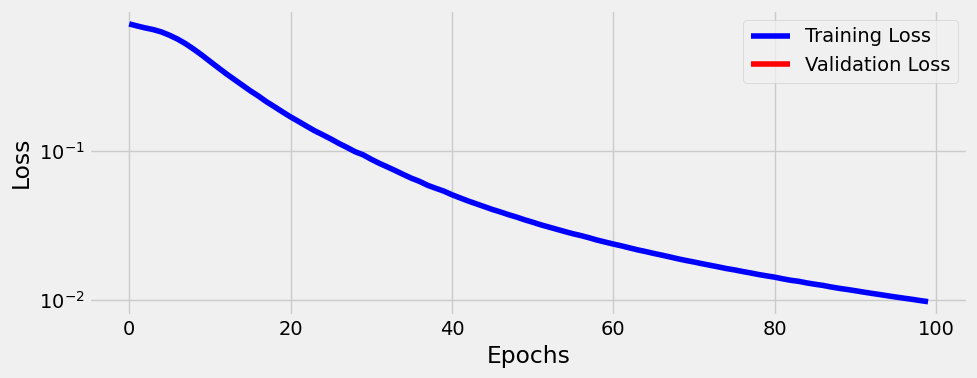

In [152]:
fig = sbs_packed.plot_losses()

In [153]:
StepByStep.loader_apply(train_var_loader, sbs_packed.correct)

tensor([[66, 66],
        [62, 62]])

## ***1D Convolutions***

In [154]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1])

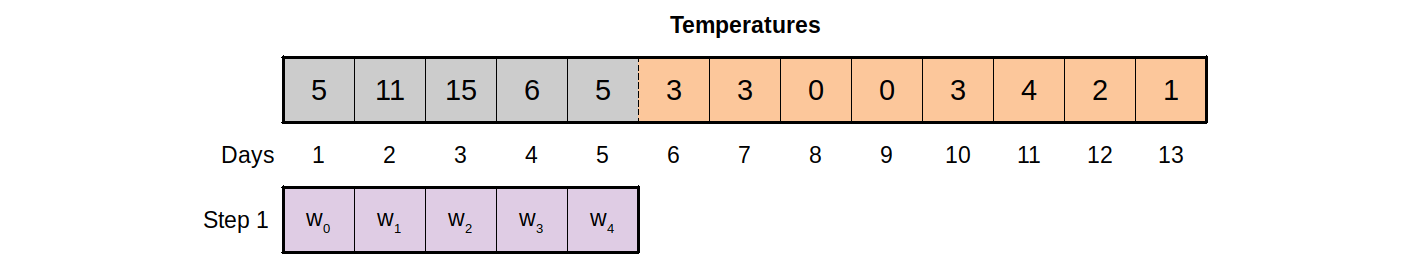

In [155]:
size = 5
weight = torch.ones(size) * 0.2

F.conv1d(torch.as_tensor(temperatures).float().view(1, 1, -1), 
         weight=weight.view(1, 1, -1))

tensor([[[8.4000, 8.0000, 6.4000, 3.4000, 2.2000, 1.8000, 2.0000, 1.8000,
          2.0000]]])

### ***Shapes***

In [156]:
seqs = torch.as_tensor(points).float() # N, L, F
seqs_length_last = seqs.permute(0, 2, 1) 
seqs_length_last.shape # N, F=C, L

torch.Size([128, 2, 4])

### ***Multiple Features or Channels***

In [157]:
torch.manual_seed(17)
conv_seq = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=2, bias=False)
conv_seq.weight, conv_seq.weight.shape

(Parameter containing:
 tensor([[[-0.0658,  0.0351],
          [ 0.3302, -0.3761]]], requires_grad=True),
 torch.Size([1, 2, 2]))

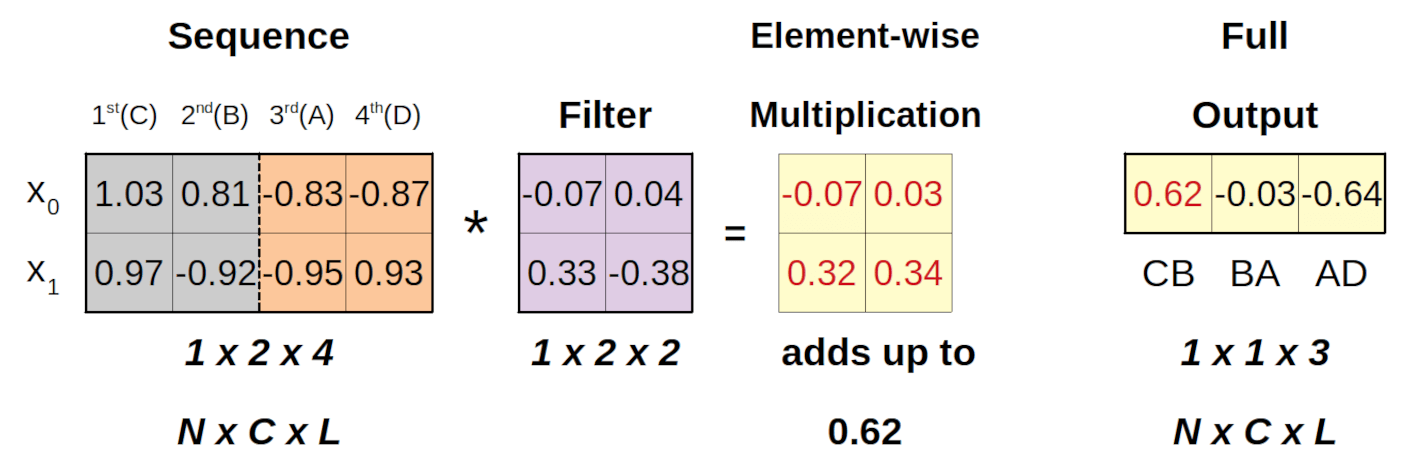

In [158]:
conv_seq(seqs_length_last[0:1])

tensor([[[ 0.6241, -0.0274, -0.6412]]], grad_fn=<ConvolutionBackward0>)

### ***Dilation***1

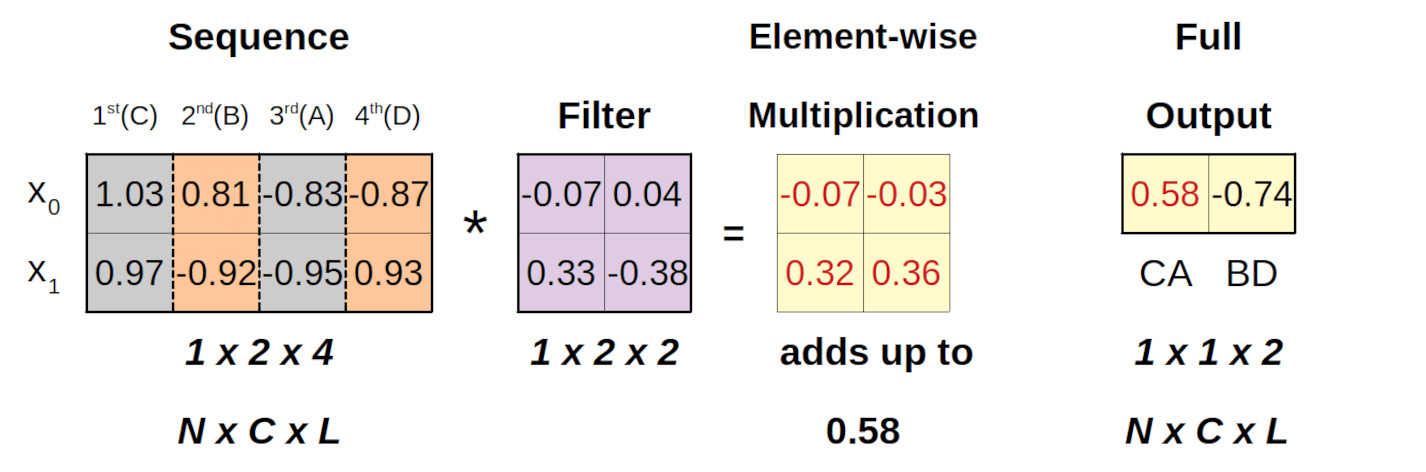

In [159]:
torch.manual_seed(17)
conv_dilated = nn.Conv1d(in_channels=2, out_channels=1, kernel_size=2, dilation=2, bias=False)
conv_dilated.weight, conv_dilated.weight.shape

(Parameter containing:
 tensor([[[-0.0658,  0.0351],
          [ 0.3302, -0.3761]]], requires_grad=True),
 torch.Size([1, 2, 2]))

In [160]:
conv_dilated(seqs_length_last[0:1])

tensor([[[ 0.5793, -0.7376]]], grad_fn=<ConvolutionBackward0>)

### ***Data Preparation***

In [161]:
train_data = TensorDataset(torch.as_tensor(points).float().permute(0, 2, 1), 
                           torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float().permute(0, 2, 1), 
                          torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

In [162]:
torch.manual_seed(21)
model = nn.Sequential()
model.add_module('conv1d', nn.Conv1d(2, 1, kernel_size=2))
model.add_module('relu', nn.ReLU(inplace=True))
model.add_module('flatten', nn.Flatten())
model.add_module('output', nn.Linear(3, 1))
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [163]:
sbs_conv1 = StepByStep(model, loss, optimizer)
sbs_conv1.set_loaders(train_loader, test_loader)
sbs_conv1.train(100)

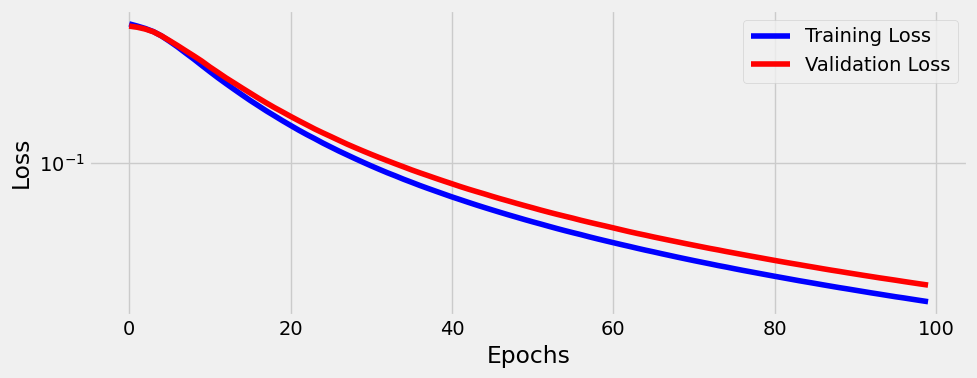

In [164]:
fig = sbs_conv1.plot_losses()

In [165]:
StepByStep.loader_apply(test_loader, sbs_conv1.correct)

tensor([[53, 53],
        [75, 75]])

In [166]:
model.conv1d.state_dict()

OrderedDict([('weight',
              tensor([[[-0.2017,  2.3691],
                       [-2.4136, -0.1616]]], device='cuda:0')),
             ('bias', tensor([-0.5586], device='cuda:0'))])

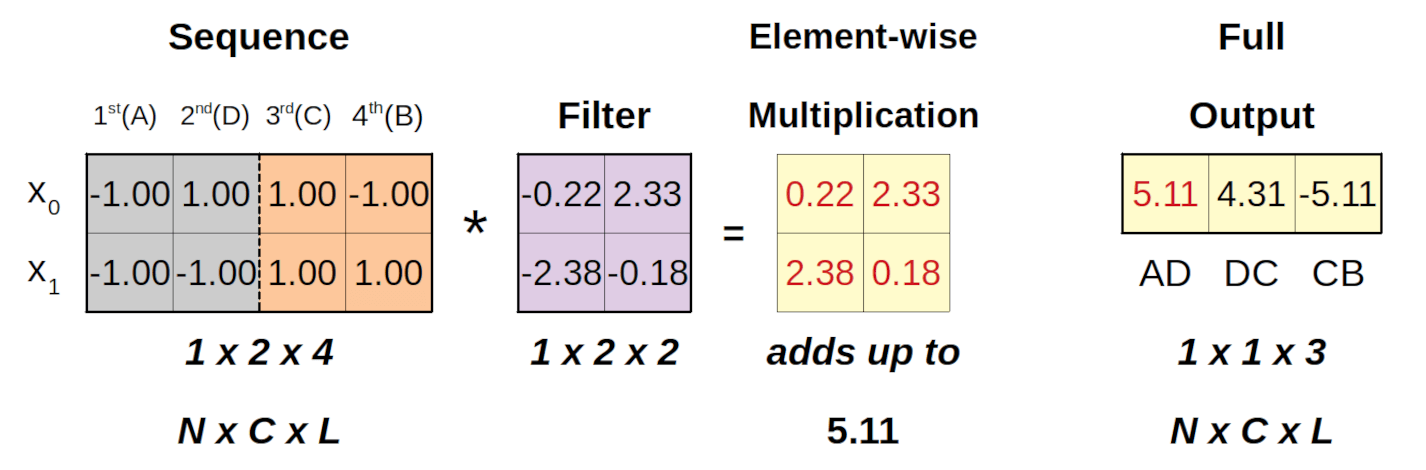

## ***Putting It All Together***

In [167]:
points, directions = generate_sequences(n=128, seed=13)
train_data = TensorDataset(torch.as_tensor(points).float(), 
                           torch.as_tensor(directions).view(-1, 1).float())
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

In [168]:
var_points, var_directions = generate_sequences(variable_len=True)

In [169]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = [torch.as_tensor(s).float() for s in x]
        self.y = torch.as_tensor(y).float().view(-1, 1)
        
    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.x)
    
train_var_data = CustomDataset(var_points, var_directions)

In [170]:
def pack_collate(batch):
    X = [item[0] for item in batch]
    y = [item[1] for item in batch]
    X_pack = rnn_utils.pack_sequence(X, enforce_sorted=False)

    return X_pack, torch.as_tensor(y).view(-1, 1)

train_var_loader = DataLoader(train_var_data, batch_size=16, shuffle=True, collate_fn=pack_collate)

In [171]:
class SquareModelOne(nn.Module):
    def __init__(self, n_features, hidden_dim, n_outputs, rnn_layer=nn.LSTM, **kwargs):
        super(SquareModelOne, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.n_outputs = n_outputs
        self.hidden = None
        self.cell = None
        self.basic_rnn = rnn_layer(self.n_features, self.hidden_dim, batch_first=True, **kwargs)
        output_dim = (self.basic_rnn.bidirectional + 1) * self.hidden_dim
        # Classifier to produce as many logits as outputs
        self.classifier = nn.Linear(output_dim, self.n_outputs)
        
    def forward(self, X):
        is_packed = isinstance(X, nn.utils.rnn.PackedSequence)
        # X is a PACKED sequence, there is no need to permute
        
        rnn_out, self.hidden = self.basic_rnn(X)
        if isinstance(self.basic_rnn, nn.LSTM):
            self.hidden, self.cell = self.hidden
        
        if is_packed:
            # unpack the output
            batch_first_output, seq_sizes = rnn_utils.pad_packed_sequence(rnn_out, batch_first=True)        
            seq_slice = torch.arange(seq_sizes.size(0))
        else:
            batch_first_output = rnn_out
            seq_sizes = 0 # so it is -1 as the last output
            seq_slice = slice(None, None, None) # same as ':'
            
        # only last item in sequence (N, 1, H)
        last_output = batch_first_output[seq_slice, seq_sizes-1]
        
        # classifier will output (N, 1, n_outputs)
        out = self.classifier(last_output)
                
        # final output is (N, n_outputs)
        return out.view(-1, self.n_outputs)

In [172]:
torch.manual_seed(21)
model = SquareModelOne(n_features=2, hidden_dim=2, n_outputs=1,
                       rnn_layer=nn.LSTM, num_layers=1, bidirectional=True)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [173]:
sbs_one = StepByStep(model, loss, optimizer)
#sbs_one.set_loaders(train_loader)
sbs_one.set_loaders(train_var_loader)
sbs_one.train(100)

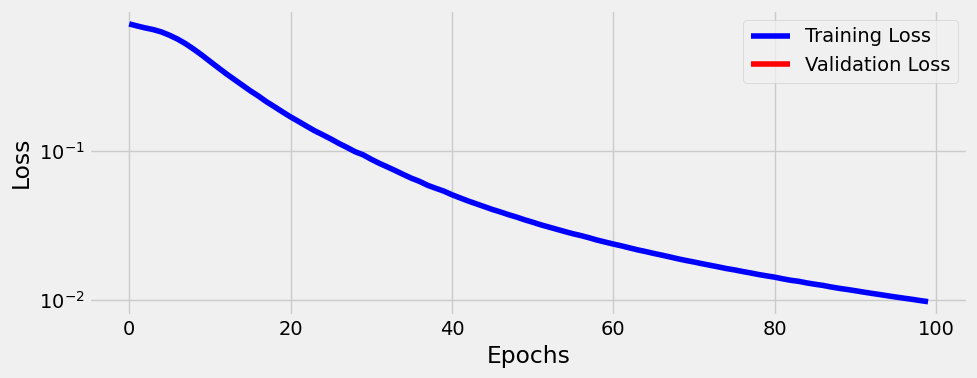

In [174]:
fig = sbs_one.plot_losses()

In [175]:
StepByStep.loader_apply(train_var_loader, sbs_one.correct)

tensor([[66, 66],
        [62, 62]])